## Problem: 
Payment defaults are detrimental to the business and are a significant cost factor.
Are there any key trends in the data which can help me avoid default-prone customers in the future?

# 0. Import

In [1]:
import numpy             as np
import pandas            as pd
import seaborn           as sns


In [2]:
import matplotlib        as mpl
import plotly.express    as px
import matplotlib.pyplot as plt
import missingno         as msno

%matplotlib inline
plt.style.use('seaborn')

In [3]:
from matplotlib.cbook import boxplot_stats

Settings

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (20,10)

0. Import
1. Checks

EDA:
Create something I can see for their pay amount history

People who pay on different:
Time of day
Weekday 

People who 

Variables to contruct:
number of contracts
number of companies
hours
week date
month 

There might be payment frequency that can predict whether someone will default or not?
payment average over time?

In [5]:
clients  = pd.read_csv("Clients.csv")
payments = pd.read_csv("Payments.csv")

payments["transaction_date"] = pd.to_datetime(payments["transaction_date"],unit='s').dt.date
payments.transaction_date

0        2018-05-22
1        2017-11-26
2        2018-02-22
3        2018-06-24
4        2018-03-22
            ...    
25554    2018-07-19
25555    2018-07-16
25556    2018-07-19
25557    2018-07-22
25558    2018-07-22
Name: transaction_date, Length: 25559, dtype: object

In [6]:
px.histogram(payments.payment_amt,height=800)

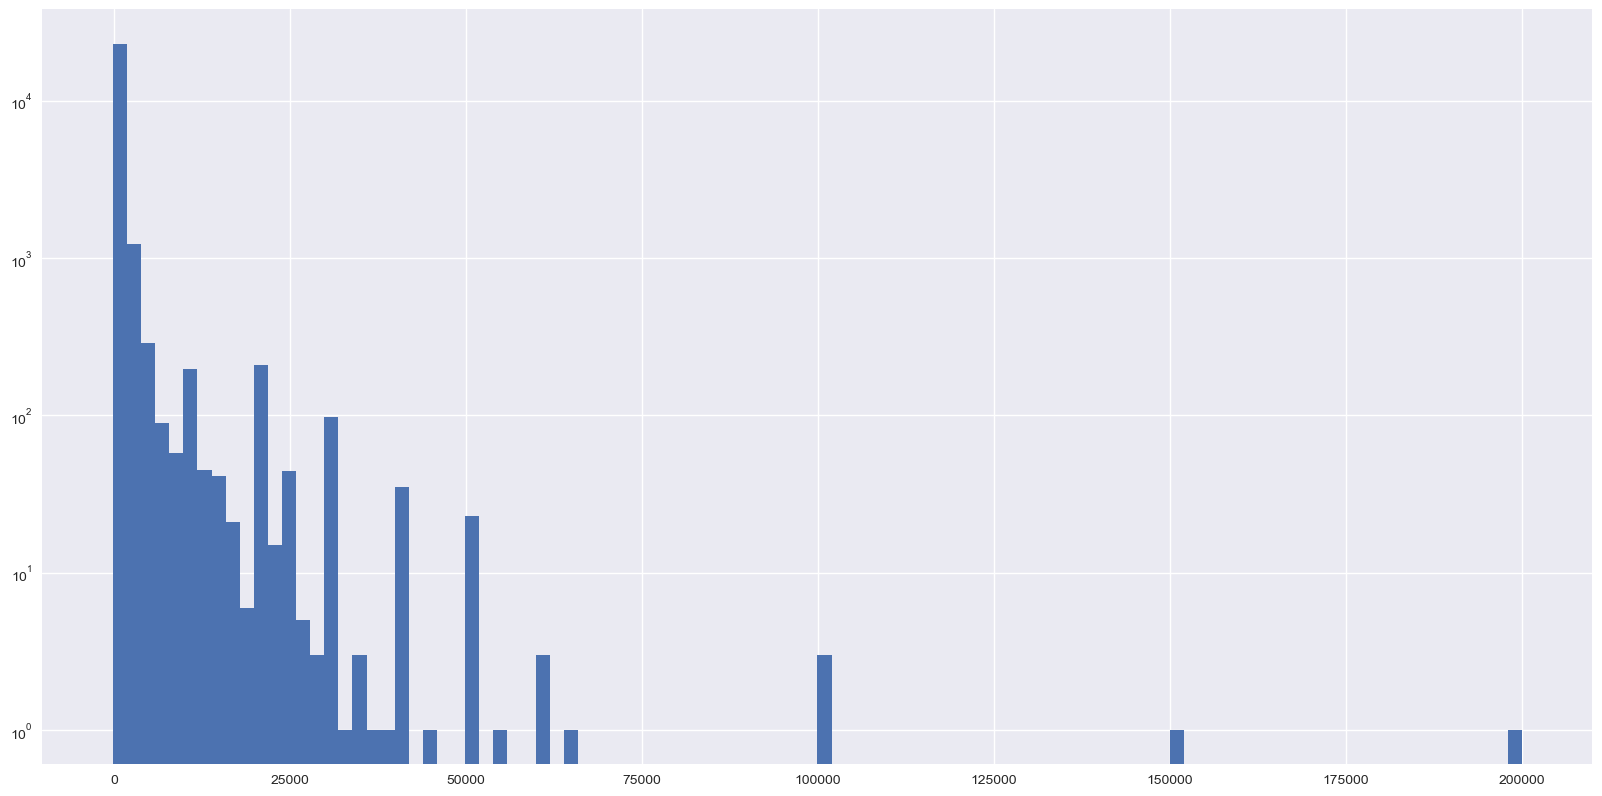

In [7]:
plt.hist(payments.payment_amt, bins=100, log=True)
plt.show()

In [8]:
clients.sort_values(by="client_id").reset_index().drop(columns="index")

,client_id,entity_type,entity_year_established
0,1,Other Partnership,2006
1,2,Australian Private Company,2001
2,3,Australian Private Company,2002
3,4,Australian Private Company,2007
4,5,Australian Private Company,2007
...,...,...,...
1282,1277,Individual/Sole Trader,2004
1283,1278,Fixed Unit Trust,2007
1284,1279,Discretionary Trading Trust,2017
1285,1280,Australian Private Company,2016


# 1. Checks and Descriptive Statistics

In [9]:
payments.describe()

,transaction_id,contract_id,client_id,payment_amt
count,25559.000000,25559.000000,25559.000000,25559.000000
mean,12780.000000,758.221409,602.886811,1221.455691
std,7378.392101,352.190207,344.782295,4346.049363
min,1.000000,1.000000,1.000000,-136.660000
25%,6390.500000,510.000000,308.000000,93.330000
50%,12780.000000,732.000000,593.000000,266.660000
75%,19169.500000,991.000000,894.000000,833.330000
max,25559.000000,1643.000000,1281.000000,200000.050000


In [10]:
clients.describe()

,client_id,entity_year_established
count,1287.000000,1287.000000
mean,641.025641,2009.072261
std,369.778060,5.708598
min,1.000000,1999.000000
25%,321.500000,2004.000000
50%,640.000000,2010.000000
75%,960.500000,2014.000000
max,1281.000000,2018.000000


### 1.1 Missing Values

In [ ]:
msno.matrix(clients)
plt.show()

In [ ]:
msno.matrix(payments)
plt.show()

### 1.2 Unique Clients

Is the number of unique client_id = n_row of clients data?

In [13]:
print("Number of Clients:", payments.client_id.nunique())
print("Rows of Client Data:", clients.shape[0])

Number of Clients: 1281
Rows of Client Data: 1287


This means there are clients out there that owns more than 1 company

In [14]:
# Groups on client_id and count their occurrences, repeated client_id (> 1) means they own more company
clients_with_companies = clients.groupby("client_id").count().sort_values(by="entity_type", ascending=False)
clients_with_companies_list = clients_with_companies[clients_with_companies.entity_type > 1].index.tolist()

In [15]:
clients[clients.client_id.isin(clients_with_companies_list)].sort_values(by="client_id")

,client_id,entity_type,entity_year_established
401,165,Australian Private Company,2015
1115,165,Individual/Sole Trader,2006
332,473,Australian Private Company,2016
350,473,Individual/Sole Trader,2008
245,591,Australian Private Company,2013
306,591,Australian Private Company,2007
816,591,Australian Private Company,2015
1063,797,Discretionary Investment Trust,2016
1275,797,Australian Private Company,2002
1172,1262,Australian Private Company,2005


In [16]:
n_types_company = clients.groupby("entity_type").client_id.count().reset_index().rename(columns={"client_id":"total"}).sort_values(by="total")
n_types_company

,entity_type,total
1,Australian Proprietary Company,1
7,Hybrid Trust,1
3,Discretionary Investment Trust,3
6,Fixed Unit Trust,4
2,Australian Public Company,6
9,Other Partnership,10
4,Discretionary Trading Trust,12
5,Family Partnership,39
8,Individual/Sole Trader,457
0,Australian Private Company,754


In [17]:
# sns.barplot(data=company_default_rate, x="entity_type", y="default_pct")
# px.bar(company_default_rate, x="entity_type", y="default_pct",width=1000, height=500)


Problem: It is harder to interpret companies that we don't have much data to such as Hybrid Trust and Discretionary Investment Trust. <br>
Their high default percentage are due to smaller sample size

### 1.3 Negative Values

In [18]:
payments.describe()

,transaction_id,contract_id,client_id,payment_amt
count,25559.000000,25559.000000,25559.000000,25559.000000
mean,12780.000000,758.221409,602.886811,1221.455691
std,7378.392101,352.190207,344.782295,4346.049363
min,1.000000,1.000000,1.000000,-136.660000
25%,6390.500000,510.000000,308.000000,93.330000
50%,12780.000000,732.000000,593.000000,266.660000
75%,19169.500000,991.000000,894.000000,833.330000
max,25559.000000,1643.000000,1281.000000,200000.050000


In [19]:
payments[payments.payment_amt < 0]

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code
5271,16270,564,259,2018-04-03,-55.00,PAYMENT
20089,18574,451,937,2018-05-03,-136.66,PAYMENT


In [20]:
payments["payment_amt"] = payments["payment_amt"].abs()
payments[payments.payment_amt < 0]

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code


In [21]:
payments.describe()

,transaction_id,contract_id,client_id,payment_amt
count,25559.000000,25559.000000,25559.000000,25559.000000
mean,12780.000000,758.221409,602.886811,1221.470688
std,7378.392101,352.190207,344.782295,4346.045148
min,1.000000,1.000000,1.000000,0.010000
25%,6390.500000,510.000000,308.000000,93.330000
50%,12780.000000,732.000000,593.000000,266.660000
75%,19169.500000,991.000000,894.000000,833.330000
max,25559.000000,1643.000000,1281.000000,200000.050000


### 1.4 Time frame of data set

In [22]:
date_start = payments.transaction_date.min()
date_end   = payments.transaction_date.max()
n_days     = date_end - date_start
print("The dataset spans from: {} to {}. A total of {}" .format(payments.transaction_date.min(), payments.transaction_date.max(), n_days))

The dataset spans from: 2017-07-02 to 2018-07-24. A total of 387 days, 0:00:00


# 2. EDA

## Intro

In [23]:
df = pd.merge(payments, clients, on="client_id")
df["payment_code"] = df["payment_code"].replace({"PAYMENT": True, "DEFAULT": False})
df

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
0,20175,927,1,2018-05-22,66.66,True,Other Partnership,2006
1,8485,927,1,2017-11-26,66.66,True,Other Partnership,2006
2,13778,927,1,2018-02-22,66.66,True,Other Partnership,2006
3,22768,927,1,2018-06-24,66.66,True,Other Partnership,2006
4,15698,927,1,2018-03-22,66.66,True,Other Partnership,2006
...,...,...,...,...,...,...,...,...
25849,25075,1603,1280,2018-07-19,1666.68,True,Australian Private Company,2016
25850,24711,1603,1280,2018-07-16,0.01,True,Australian Private Company,2016
25851,25076,1603,1280,2018-07-19,64.99,True,Australian Private Company,2016
25852,25132,1627,1281,2018-07-22,0.01,True,Australian Private Company,2012


In [24]:
df.describe()

,transaction_id,contract_id,client_id,payment_amt,entity_year_established
count,25854.000000,25854.000000,25854.000000,25854.000000,25854.000000
mean,12781.997138,758.568384,602.831477,1225.567675,2009.150576
std,7383.715669,352.121377,343.589521,4343.662446,5.616094
min,1.000000,1.000000,1.000000,0.010000,1999.000000
25%,6388.250000,510.000000,309.000000,93.330000,2005.000000
50%,12782.500000,730.000000,591.000000,266.660000,2011.000000
75%,19181.750000,992.000000,891.000000,833.330000,2014.000000
max,25559.000000,1643.000000,1281.000000,200000.050000,2018.000000


##### Company default status Datadframe

In [25]:
default_status = df.groupby(['client_id', 'entity_type', 'entity_year_established'])['payment_code'].all().reset_index().sort_values(by="client_id")
default_status

,client_id,entity_type,entity_year_established,payment_code
0,1,Other Partnership,2006,True
1,2,Australian Private Company,2001,True
2,3,Australian Private Company,2002,True
3,4,Australian Private Company,2007,True
4,5,Australian Private Company,2007,True
...,...,...,...,...
1282,1277,Individual/Sole Trader,2004,True
1283,1278,Fixed Unit Trust,2007,True
1284,1279,Discretionary Trading Trust,2017,True
1285,1280,Australian Private Company,2016,True


In [26]:
default_status_list = default_status[["client_id", "payment_code"]]
default_status_list

,client_id,payment_code
0,1,True
1,2,True
2,3,True
3,4,True
4,5,True
...,...,...
1282,1277,True
1283,1278,True
1284,1279,True
1285,1280,True


In [27]:
default_status_list.payment_code.value_counts()

True     919
False    368
Name: payment_code, dtype: int64

In [28]:
entity = df.groupby(["client_id", "entity_type", "entity_year_established", "payment_code", "transaction_date"]).payment_amt.sum().reset_index()
entity["payment_code"] = entity["payment_code"].replace({True: "PAYMENT",False : "DEFAULT"})
default_count = entity.groupby(["client_id", "entity_type", "entity_year_established"]).apply(lambda x: (x['payment_code'] == 'DEFAULT').sum()).reset_index(name='default_count')
default_count

,client_id,entity_type,entity_year_established,default_count
0,1,Other Partnership,2006,0
1,2,Australian Private Company,2001,0
2,3,Australian Private Company,2002,0
3,4,Australian Private Company,2007,0
4,5,Australian Private Company,2007,0
...,...,...,...,...
1282,1277,Individual/Sole Trader,2004,0
1283,1278,Fixed Unit Trust,2007,0
1284,1279,Discretionary Trading Trust,2017,0
1285,1280,Australian Private Company,2016,0


<AxesSubplot:ylabel='payment_code'>

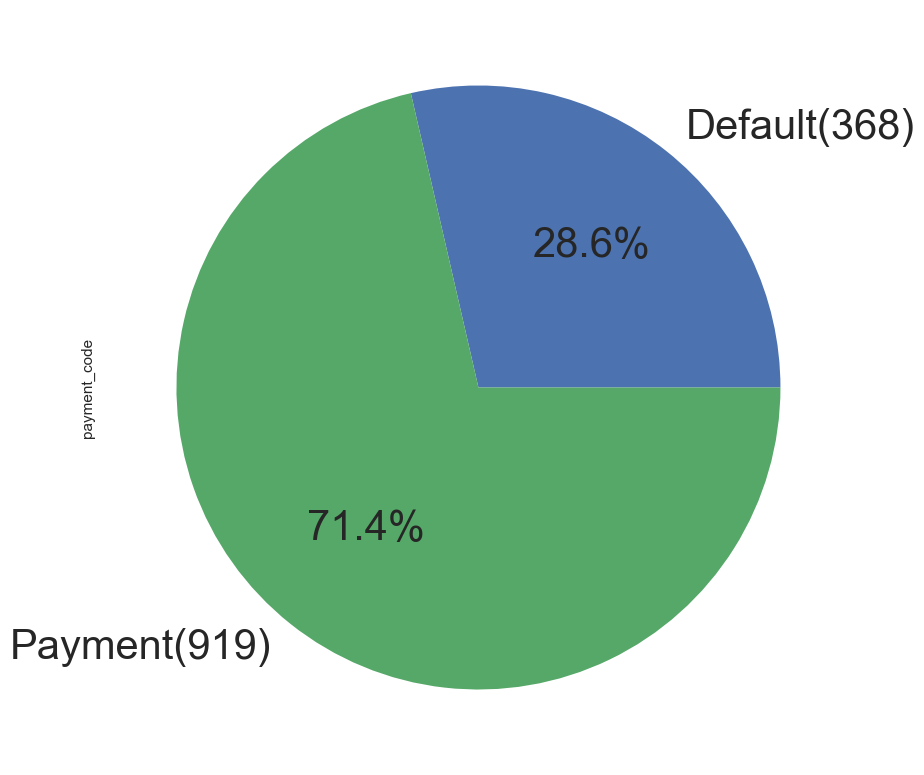

In [29]:
default_status.groupby("payment_code").payment_code.count().plot.pie(y="client_id", autopct='%1.1f%%', textprops={'fontsize': 30}, labels=['Default(368)','Payment(919)'])

28.6% of the Companies has a history of defaulting

## 2.1 Effects of Total Liability of a Client to Default 

##### Code

Creates a dataframe of whether a clients has default before or not:

In [30]:
# TRUE  = Did not default
# FALSE = Has defaulted before
client_default_df = df.groupby(['client_id'])['payment_code'].all().reset_index().sort_values(by="client_id")
client_default_df

,client_id,payment_code
0,1,True
1,2,True
2,3,True
3,4,True
4,5,True
...,...,...
1276,1277,True
1277,1278,True
1278,1279,True
1279,1280,True


Calculates the total liability of a client <br>
Whether a company has more than one contracts or more than one contract at a time will be indicated when working with predictive model <br>
For simplicity we take total liability to be the sum of all contract that client owns for one of its company <br>

In [31]:
total_liability = df.groupby(["client_id"]).payment_amt.sum().reset_index()
total_liability

,client_id,payment_amt
0,1,9016.68
1,2,25950.03
2,3,4261.68
3,4,8016.56
4,5,5211.69
...,...,...
1276,1277,21731.73
1277,1278,9999.98
1278,1279,108658.32
1279,1280,21731.73


In [32]:
new = df.groupby(['client_id'])['payment_code'].all().reset_index().sort_values(by="client_id")
new

,client_id,payment_code
0,1,True
1,2,True
2,3,True
3,4,True
4,5,True
...,...,...
1276,1277,True
1277,1278,True
1278,1279,True
1279,1280,True


In [33]:
total_liability = pd.merge(total_liability, new, on="client_id").sort_values(by="payment_amt")
total_liability

,client_id,payment_amt,payment_code
386,387,0.01,True
133,134,0.01,True
812,813,47.34,False
1094,1095,54.70,False
529,530,102.02,False
...,...,...,...
1258,1259,200541.98,True
622,623,200876.24,True
1268,1269,217316.74,True
1194,1195,284276.59,False


In [34]:
total_liability_payment = total_liability[total_liability.payment_code == True]
total_liability_default = total_liability[total_liability.payment_code == False]


In [35]:
total_liability_payment.describe()
total_liability_default.describe()

,client_id,payment_amt
count,365.000000,365.000000
mean,608.383562,27447.992411
std,342.707041,36222.371045
min,7.000000,47.340000
25%,330.000000,7185.750000
50%,610.000000,17250.000000
75%,890.000000,35322.630000
max,1254.000000,443152.500000


In [36]:
def removeOutlier(dataframe, variable):
    """
    Takes in a dataframe and variable/feature of interest
    
    Removes outlier for the distribution of that variable

    Args:
        dataframe (_type_): _description_
        variable  (_type_): _description_

    Returns:
        pandas DataFrame
    """

    outliers  = pd.Series(boxplot_stats(dataframe[variable]).pop(0)['fliers']).to_list()
    dataframe = dataframe.drop(dataframe[dataframe[variable].isin(outliers)].index)
    return dataframe

##### Results

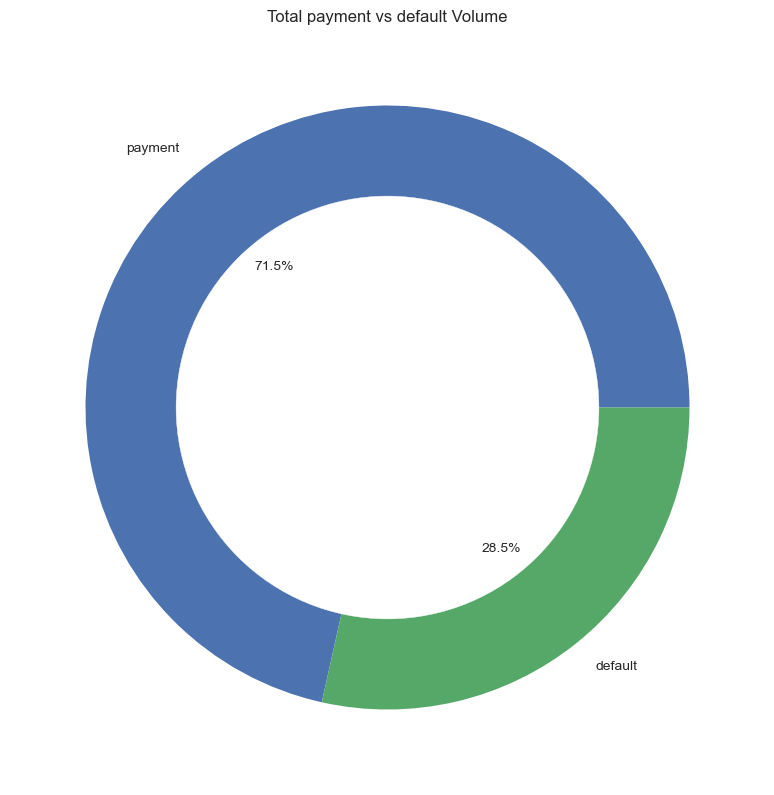

In [37]:
# Visualization of the percentage of spending vs income transaction in the dataset

# Rather than doing .sum() to count the amount transaction of each group, simply accessing the number of rows using shape is sufficient
plt.pie([total_liability_payment.shape[0], total_liability_default.shape[0]], labels=["payment", "default"], autopct='%1.1f%%')

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Total payment vs default Volume")
plt.show()

28.5% of all of our clients have a history of default

([<matplotlib.axis.XTick at 0x22056d51dc0>,
 [Text(0, 0, 'Default'), Text(1, 0, 'Payment')])

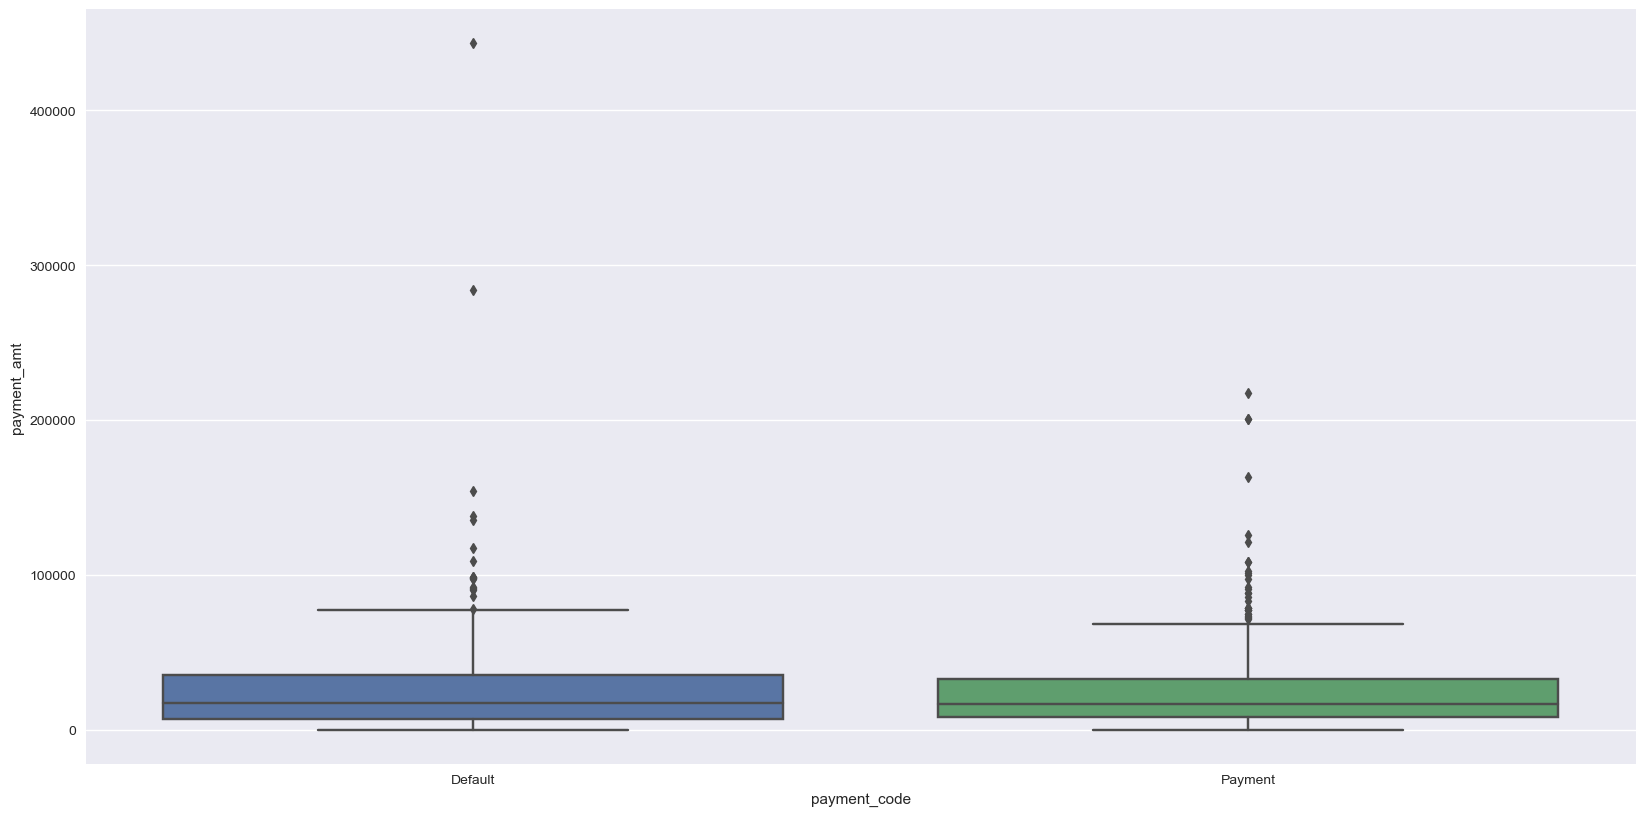

In [38]:
sns.boxplot(x="payment_code", y="payment_amt", data=total_liability)
plt.xticks([0, 1], ["Default", "Payment"])

([<matplotlib.axis.XTick at 0x2205789a100>,
 [Text(0, 0, 'Default'), Text(1, 0, 'Payment')])

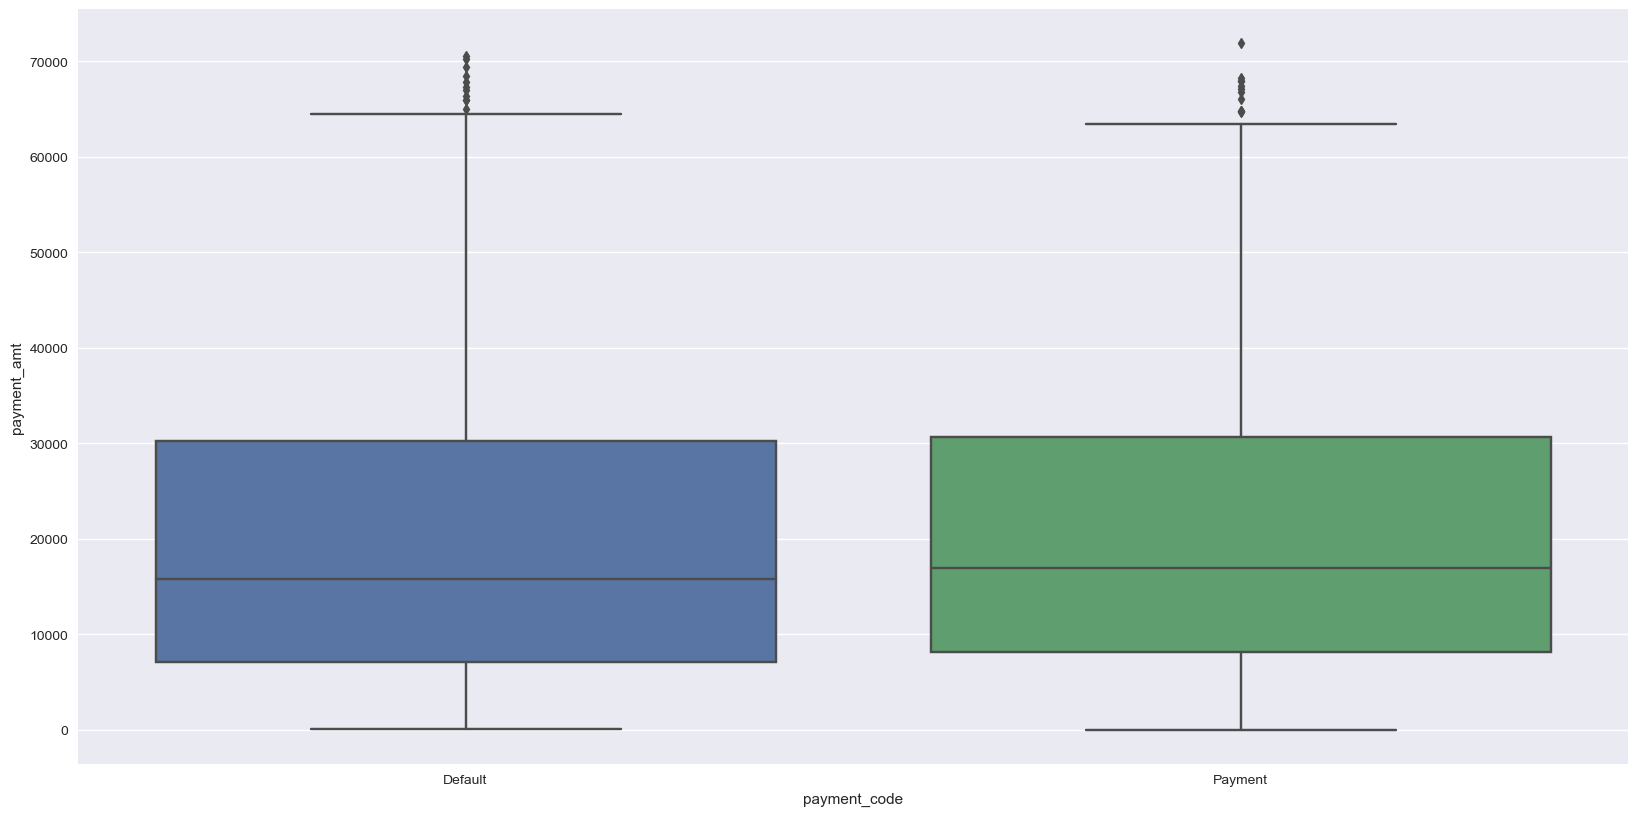

In [39]:
sns.boxplot(x="payment_code", y="payment_amt", data=removeOutlier(total_liability, "payment_amt"))
plt.xticks([0, 1], ["Default", "Payment"])

<AxesSubplot:xlabel='payment_code', ylabel='payment_amt'>

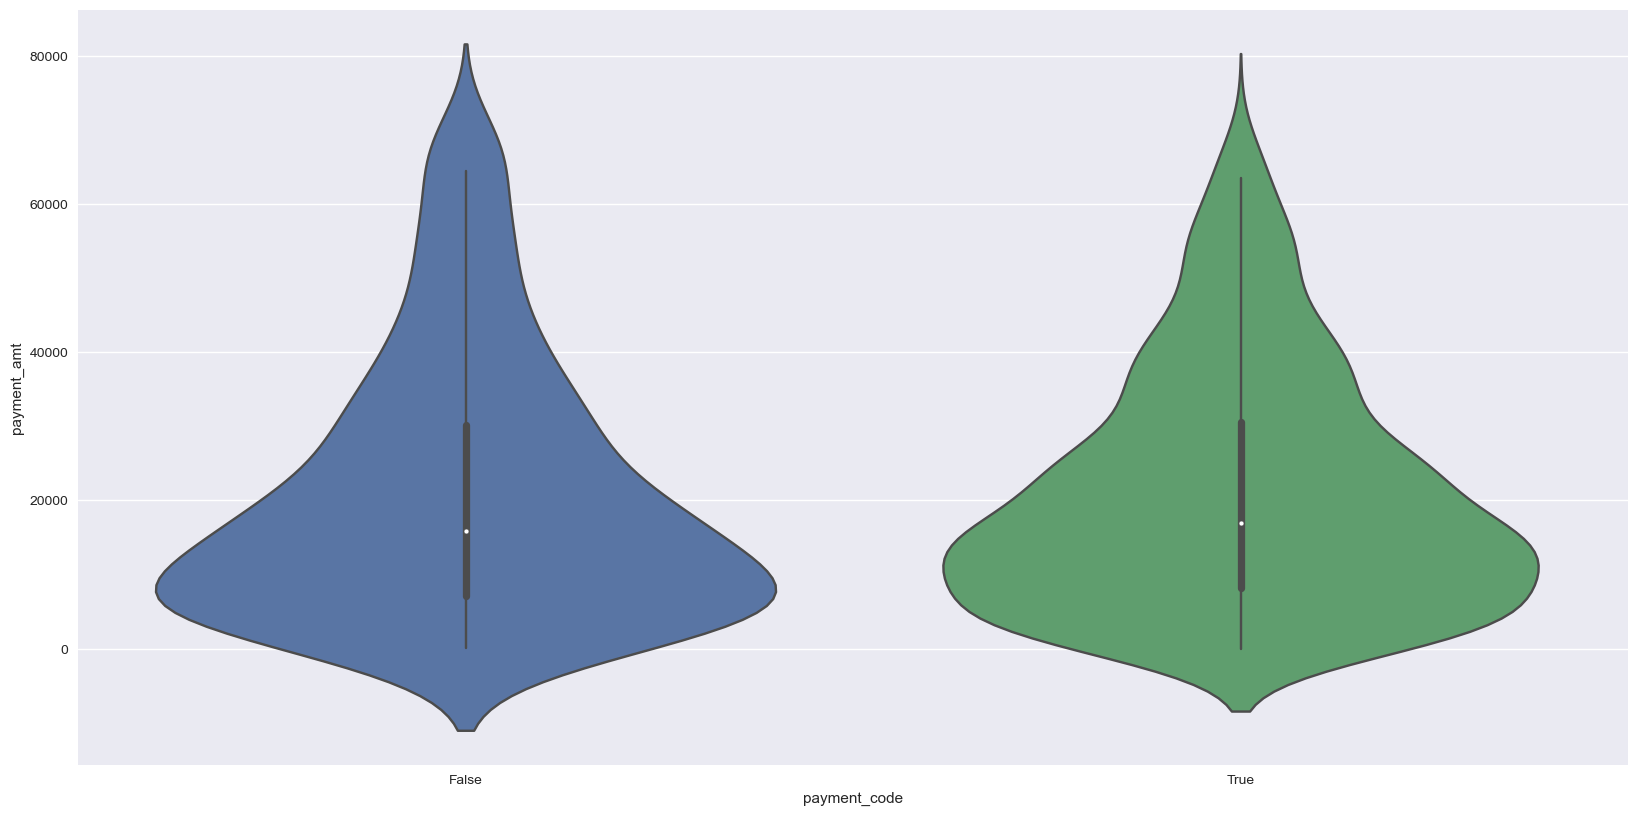

In [40]:
sns.violinplot(x="payment_code", y="payment_amt", data=removeOutlier(total_liability, "payment_amt"))

In [41]:
test = total_liability

In [42]:
test = removeOutlier(total_liability, "payment_amt")

In [43]:
from sklearn.preprocessing import StandardScaler, RobustScaler
X = test.payment_amt.values
y = test.payment_code

scaler = RobustScaler()
X = scaler.fit_transform(X.reshape(-1,1))

<AxesSubplot:ylabel='payment_code'>

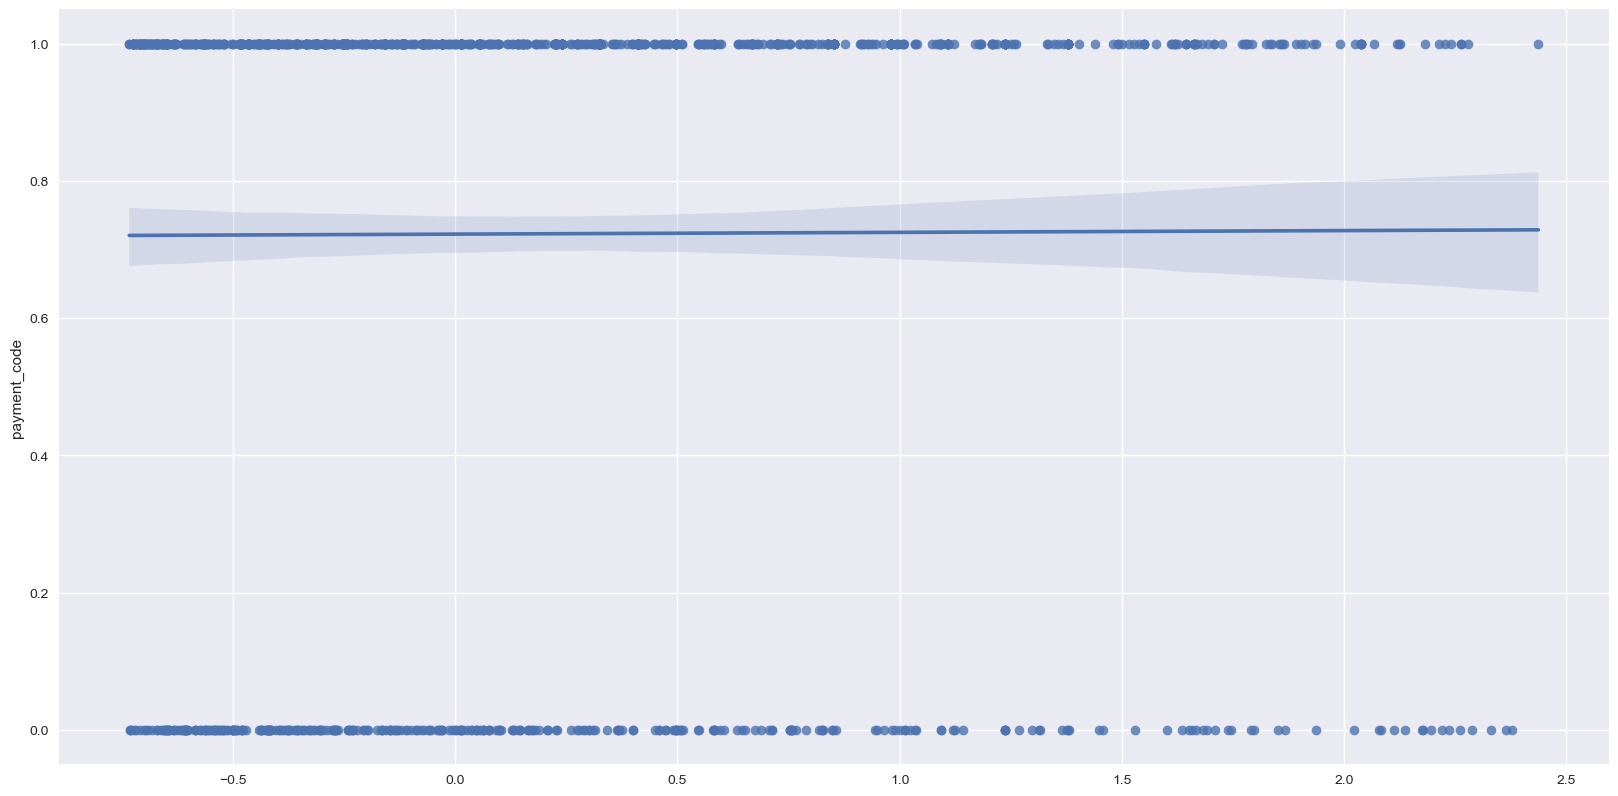

In [44]:
sns.regplot(x=X, y=y, logistic=True)


##### Conclusion

There doesn't seem to be much effect that the total liability of a client has on whether or not they default or not

## 2.2 Default Rate by Entity Type

#### 2.2.1 Entity Default Rate

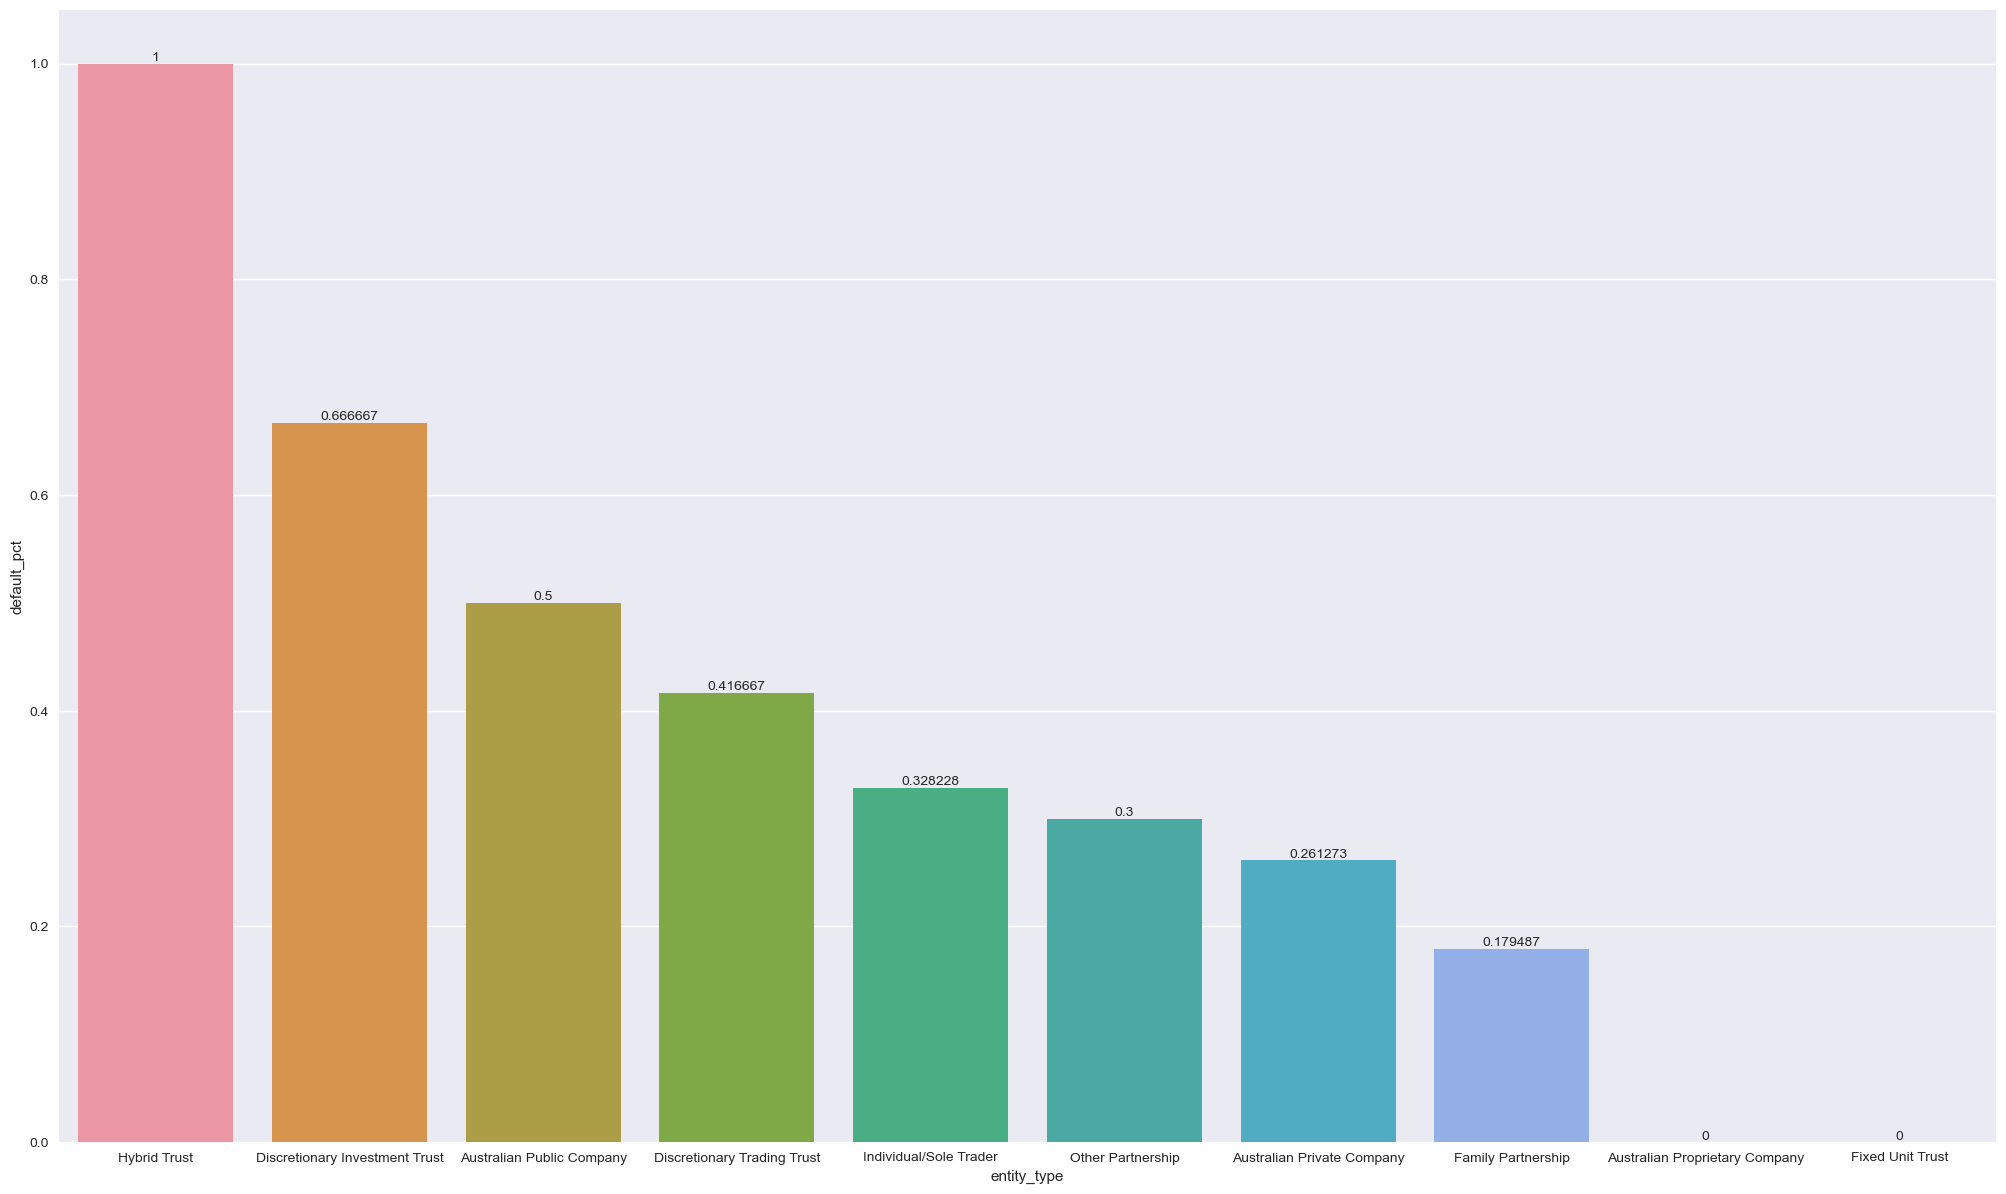

In [45]:
entity_default_rate = default_status.groupby("entity_type").payment_code.mean().reset_index(name="default_pct")
entity_default_rate["default_pct"] = 1 - entity_default_rate["default_pct"]
entity_default_rate = entity_default_rate.sort_values(by="default_pct", ascending=False)
entity_default_rate
plt.figure(figsize=(25,15))
ax = sns.barplot(data=entity_default_rate, x="entity_type", y="default_pct", order=entity_default_rate['entity_type'])
ax.bar_label(ax.containers[0])
plt.show()

In [46]:
entity_default_rate

,entity_type,default_pct
7,Hybrid Trust,1.000000
3,Discretionary Investment Trust,0.666667
2,Australian Public Company,0.500000
4,Discretionary Trading Trust,0.416667
8,Individual/Sole Trader,0.328228
9,Other Partnership,0.300000
0,Australian Private Company,0.261273
5,Family Partnership,0.179487
1,Australian Proprietary Company,0.000000
6,Fixed Unit Trust,0.000000


##### Code

In [47]:
entity_default = default_status[default_status.payment_code == False].groupby("entity_type").size().reset_index(name='default')
entity_default

,entity_type,default
0,Australian Private Company,197
1,Australian Public Company,3
2,Discretionary Investment Trust,2
3,Discretionary Trading Trust,5
4,Family Partnership,7
5,Hybrid Trust,1
6,Individual/Sole Trader,150
7,Other Partnership,3


In [48]:
entity_total = default_status.groupby("entity_type").size().reset_index(name='total')
# entity_total["default_company_pct"] = entity_default["default"] / entity_total["total"] 
entity_total 

,entity_type,total
0,Australian Private Company,754
1,Australian Proprietary Company,1
2,Australian Public Company,6
3,Discretionary Investment Trust,3
4,Discretionary Trading Trust,12
5,Family Partnership,39
6,Fixed Unit Trust,4
7,Hybrid Trust,1
8,Individual/Sole Trader,457
9,Other Partnership,10


In [49]:
entity_total = pd.merge(entity_total, entity_default, on="entity_type", how="left").fillna(0)
entity_total

,entity_type,total,default
0,Australian Private Company,754,197.0
1,Australian Proprietary Company,1,0.0
2,Australian Public Company,6,3.0
3,Discretionary Investment Trust,3,2.0
4,Discretionary Trading Trust,12,5.0
5,Family Partnership,39,7.0
6,Fixed Unit Trust,4,0.0
7,Hybrid Trust,1,1.0
8,Individual/Sole Trader,457,150.0
9,Other Partnership,10,3.0


In [50]:
entity_default_rate.set_index("entity_type", inplace=True)

##### Results

In [51]:
entity_total

,entity_type,total,default
0,Australian Private Company,754,197.0
1,Australian Proprietary Company,1,0.0
2,Australian Public Company,6,3.0
3,Discretionary Investment Trust,3,2.0
4,Discretionary Trading Trust,12,5.0
5,Family Partnership,39,7.0
6,Fixed Unit Trust,4,0.0
7,Hybrid Trust,1,1.0
8,Individual/Sole Trader,457,150.0
9,Other Partnership,10,3.0


In [52]:
px.pie(entity_total, values="default", names=entity_total.entity_type, width=500)

This above shows the percentage of the types of companies that default
* Australian Private Companies and Sole Traders makes up most of the companies 

In [53]:
print("Number of companies that has defaulted: ", entity_total.default.sum())

Number of companies that has defaulted:  368.0


#### 2.2.2 Entity Default Amount Percentage

##### Code

In [54]:
entity_default_liability = entity.groupby(["client_id", "entity_type", "entity_year_established"]).payment_amt.sum().reset_index(name='liability')
entity_default_liability = entity_default_liability.loc[:, ["client_id", "liability"]]
entity_default_liability

,client_id,liability
0,1,9016.68
1,2,25950.03
2,3,4261.68
3,4,8016.56
4,5,5211.69
...,...,...
1282,1277,21731.73
1283,1278,9999.98
1284,1279,108658.32
1285,1280,21731.73


In [55]:
entity_default_count = default_count.loc[:, ["client_id", "entity_type", "default_count"]]
entity_default_count.head(10)

,client_id,entity_type,default_count
0,1,Other Partnership,0
1,2,Australian Private Company,0
2,3,Australian Private Company,0
3,4,Australian Private Company,0
4,5,Australian Private Company,0
5,6,Australian Private Company,0
6,7,Australian Private Company,4
7,8,Individual/Sole Trader,0
8,9,Individual/Sole Trader,0
9,10,Australian Private Company,0


In [56]:
entity_amount = pd.merge(entity_default_count, entity_default_liability, on="client_id")
entity_amount

,client_id,entity_type,default_count,liability
0,1,Other Partnership,0,9016.68
1,2,Australian Private Company,0,25950.03
2,3,Australian Private Company,0,4261.68
3,4,Australian Private Company,0,8016.56
4,5,Australian Private Company,0,5211.69
...,...,...,...,...
1296,1277,Individual/Sole Trader,0,21731.73
1297,1278,Fixed Unit Trust,0,9999.98
1298,1279,Discretionary Trading Trust,0,108658.32
1299,1280,Australian Private Company,0,21731.73


In [57]:
entity_default_amount = entity_amount[entity_amount.default_count > 0].groupby("entity_type").liability.sum().reset_index(name='default')
entity_default_amount

,entity_type,default
0,Australian Private Company,7837580.09
1,Australian Public Company,56904.13
2,Discretionary Investment Trust,346732.93
3,Discretionary Trading Trust,164993.34
4,Family Partnership,129118.15
5,Hybrid Trust,21374.96
6,Individual/Sole Trader,2394188.19
7,Other Partnership,16386.78


##### Results

In [58]:
px.pie(entity_default_amount, values="default", names=entity_default_amount.entity_type, width=500)

In [60]:
default_amount = df[df.payment_code == False]
default_amount = default_amount.groupby(["client_id", "entity_type", "entity_year_established"]).payment_amt.sum().reset_index(name="default_amt")
default_amount

,client_id,entity_type,entity_year_established,default_amt
0,7,Australian Private Company,2015,1649.99
1,11,Australian Private Company,1999,2320.00
2,21,Individual/Sole Trader,1999,950.00
3,24,Individual/Sole Trader,2016,191.67
4,25,Australian Private Company,2016,5509.97
...,...,...,...,...
363,1241,Australian Private Company,2016,1778.33
364,1245,Family Partnership,2015,1933.33
365,1247,Australian Private Company,2009,1705.00
366,1252,Australian Private Company,2014,4329.16


In [61]:
default_amount

,client_id,entity_type,entity_year_established,default_amt
0,7,Australian Private Company,2015,1649.99
1,11,Australian Private Company,1999,2320.00
2,21,Individual/Sole Trader,1999,950.00
3,24,Individual/Sole Trader,2016,191.67
4,25,Australian Private Company,2016,5509.97
...,...,...,...,...
363,1241,Australian Private Company,2016,1778.33
364,1245,Family Partnership,2015,1933.33
365,1247,Australian Private Company,2009,1705.00
366,1252,Australian Private Company,2014,4329.16


All the Australian Private Company that has Defaulted

In [62]:
apc_default = default_status[(default_status.payment_code == False) & (default_status.entity_type == "Australian Private Company")]
apc_default = pd.merge(apc_default, default_amount, on=["client_id", "entity_type", "entity_year_established"])
apc_default
# 

,client_id,entity_type,entity_year_established,payment_code,default_amt
0,7,Australian Private Company,2015,False,1649.99
1,11,Australian Private Company,1999,False,2320.00
2,25,Australian Private Company,2016,False,5509.97
3,26,Australian Private Company,2011,False,1983.33
4,30,Australian Private Company,2001,False,7579.19
...,...,...,...,...,...
192,1213,Australian Private Company,2016,False,966.66
193,1241,Australian Private Company,2016,False,1778.33
194,1247,Australian Private Company,2009,False,1705.00
195,1252,Australian Private Company,2014,False,4329.16


In [63]:
apc_default_temp = apc_default.groupby("entity_year_established").default_amt.sum().reset_index()
apc_default_temp.sort_values(by="default_amt", ascending=False)

,entity_year_established,default_amt
1,2000,136985.78
15,2014,127432.77
16,2015,95109.85
4,2003,85910.28
12,2011,70895.67
13,2012,61530.72
8,2007,55744.08
14,2013,50655.55
11,2010,47676.98
7,2006,46166.64


<AxesSubplot:xlabel='entity_year_established', ylabel='default_amt'>

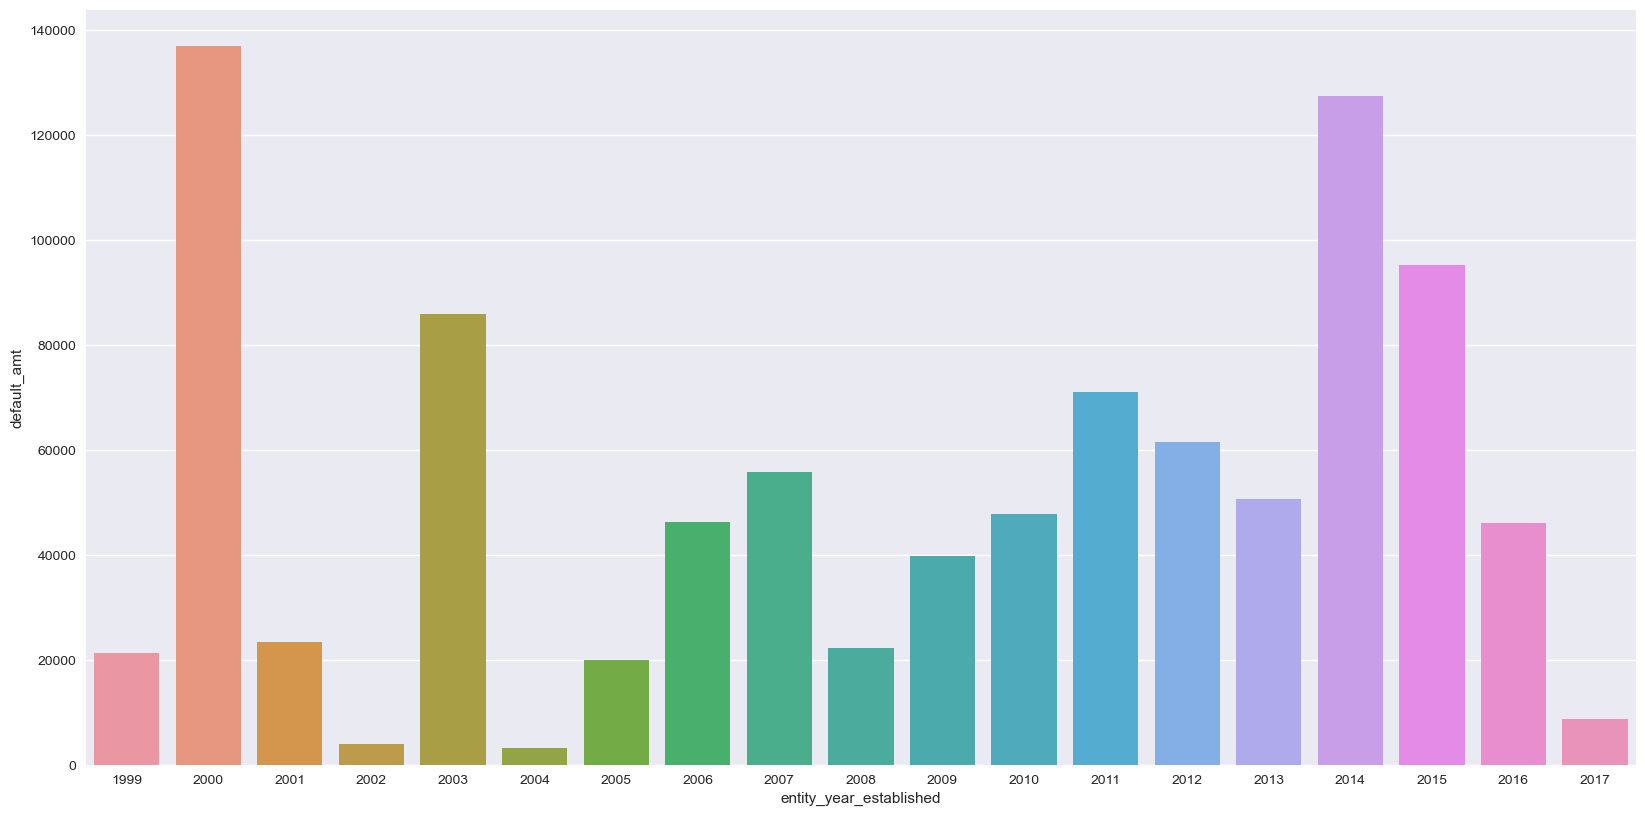

In [64]:
sns.barplot(x=apc_default_temp.entity_year_established, y=apc_default_temp.default_amt)

In [65]:
px.pie(apc_default_temp, values="default_amt", names=apc_default_temp.entity_year_established, width=700)

Sole trader liability on year

In [66]:
ist_default = default_status[(default_status.payment_code == False) & (default_status.entity_type == "Individual/Sole Trader")]
ist_default = pd.merge(ist_default, default_amount, on=["client_id", "entity_type", "entity_year_established"])
ist_default
ist_default_temp = ist_default.groupby("entity_year_established").default_amt.sum().reset_index()
ist_default_temp
px.pie(ist_default_temp, values="default_amt", names=ist_default_temp.entity_year_established, width=500)

In [67]:
ist_default_temp.sort_values(by="default_amt", ascending=False)

,entity_year_established,default_amt
1,2000,56260.61
15,2014,52072.94
14,2013,41481.63
16,2015,33974.87
5,2004,32068.23
10,2009,29709.08
8,2007,24656.55
18,2017,17229.56
13,2012,15703.28
12,2011,14607.31


<AxesSubplot:xlabel='entity_year_established', ylabel='default_amt'>

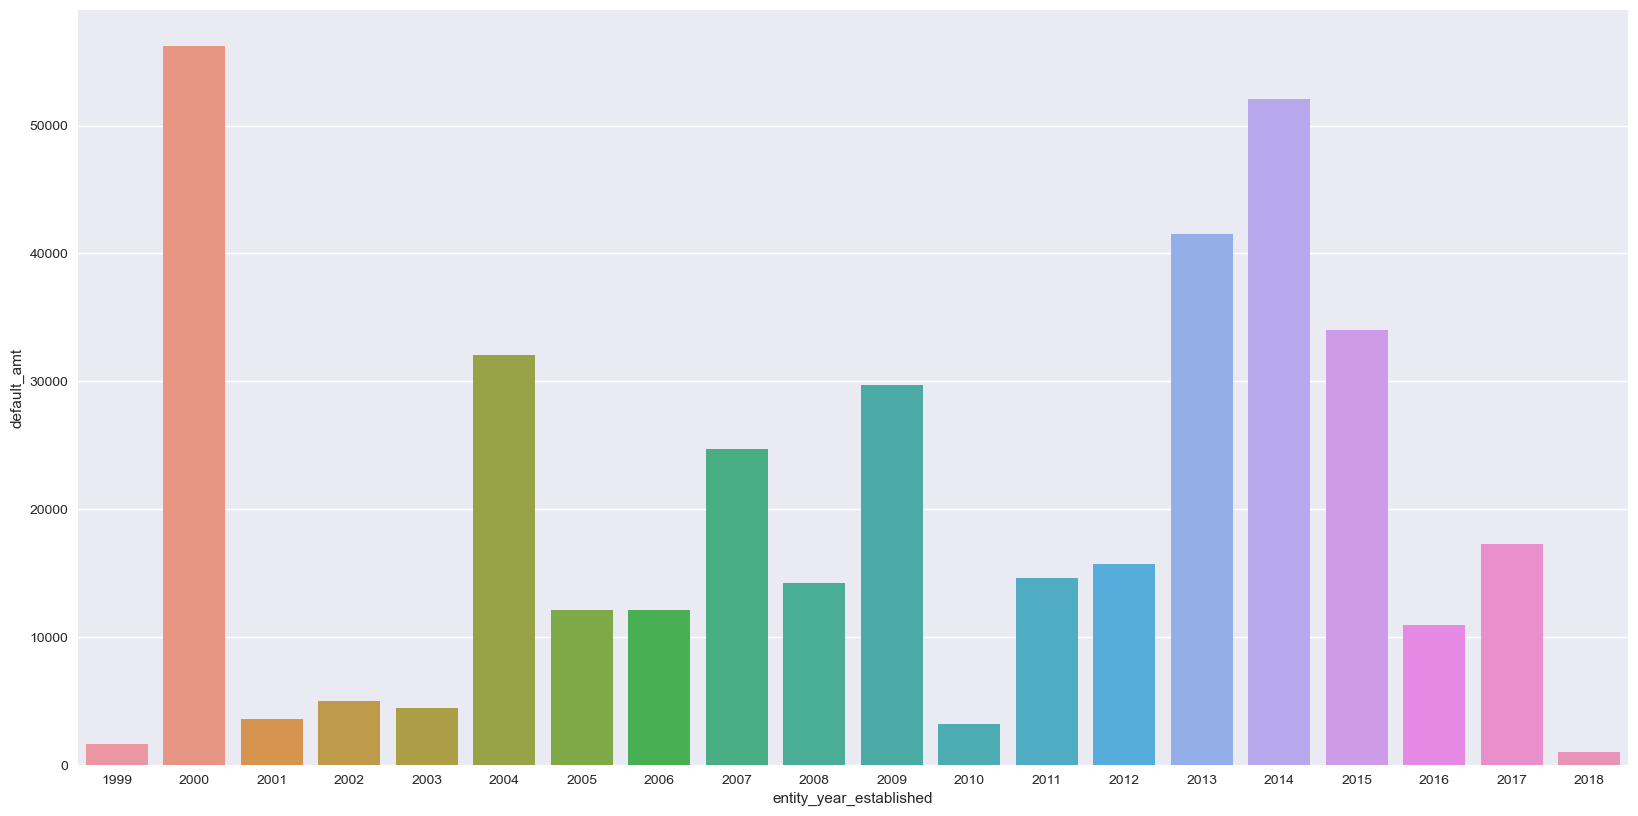

In [68]:
sns.barplot(x=ist_default_temp.entity_year_established, y=ist_default_temp.default_amt)

## 2.3 Default Rate by Year

d:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



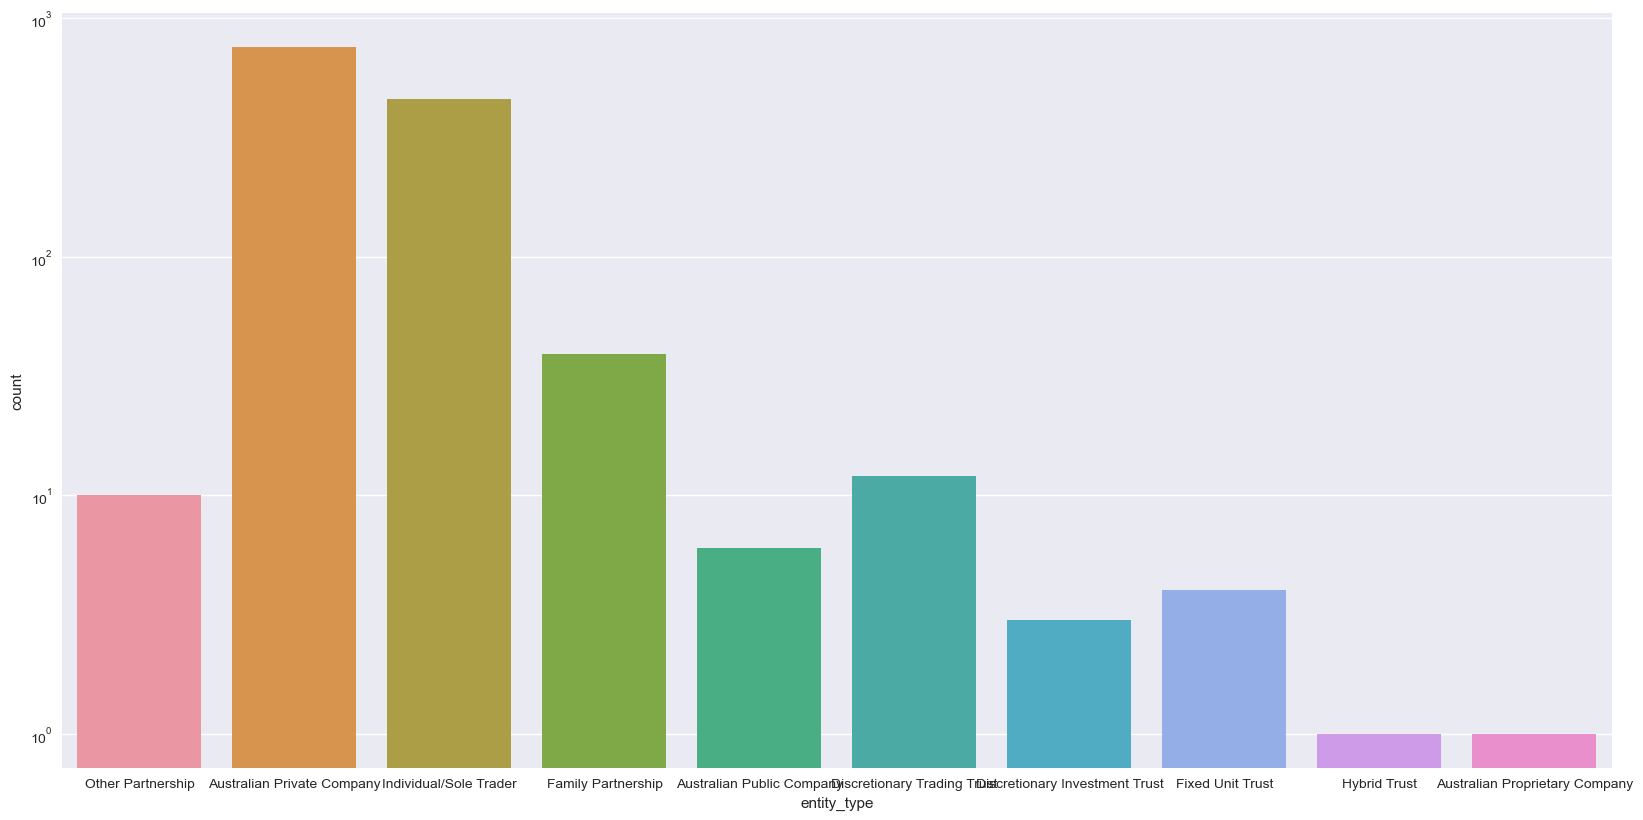

In [69]:
sns.countplot(default_status.entity_type).set_yscale('log')

<AxesSubplot:>

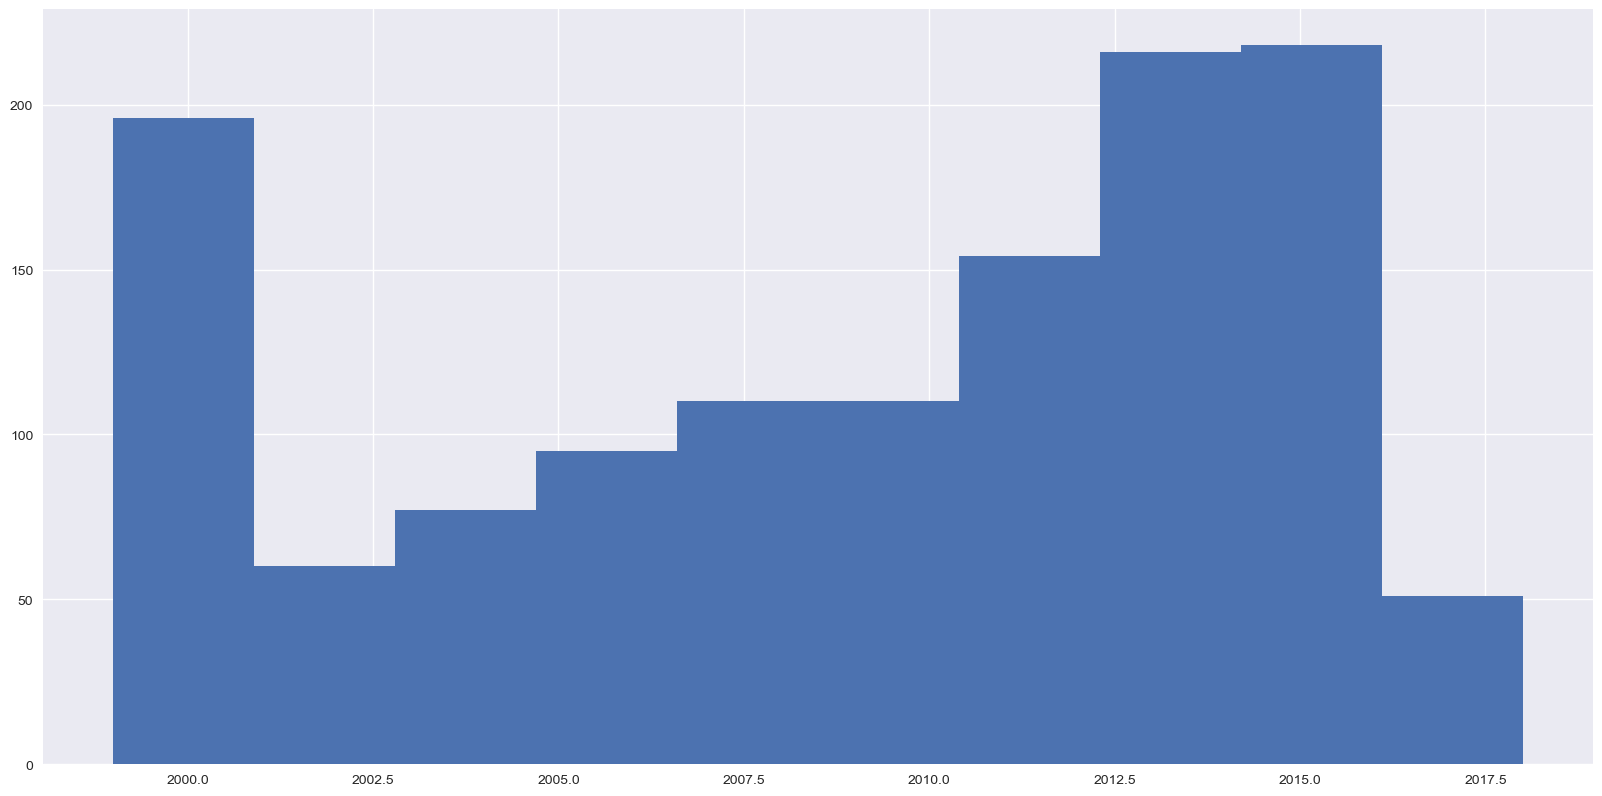

In [70]:
default_status.entity_year_established.hist()

<AxesSubplot:xlabel='entity_year_established', ylabel='default_pct'>

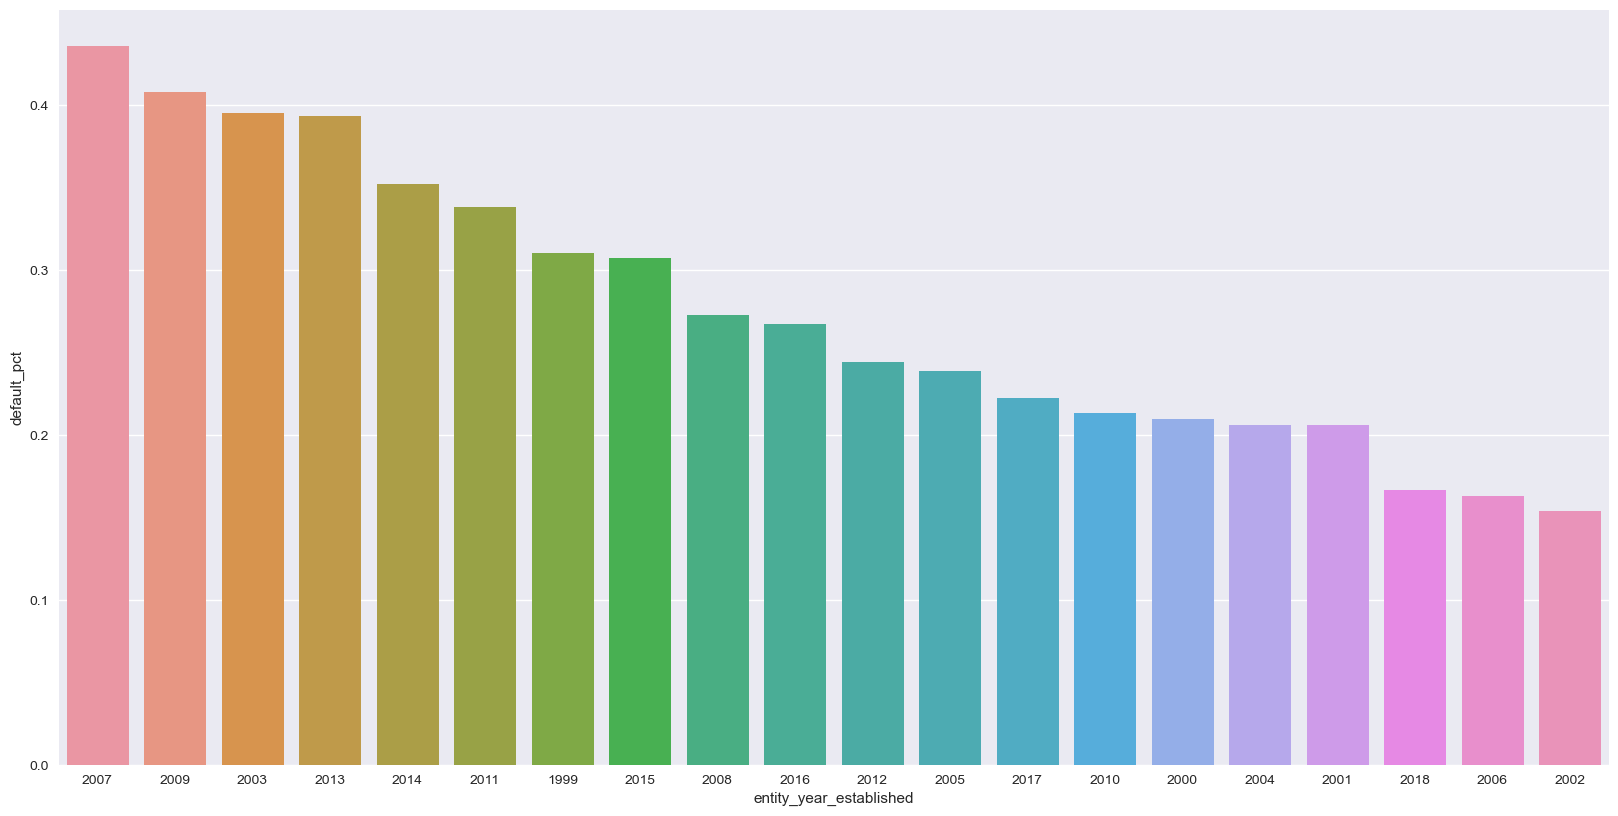

In [71]:
entity_default_rate = default_status.groupby("entity_year_established").payment_code.mean().reset_index(name="default_pct")
entity_default_rate["default_pct"] = 1 - entity_default_rate["default_pct"]
entity_default_rate = entity_default_rate.sort_values(by="default_pct", ascending=False)
entity_default_rate
sns.barplot(data=entity_default_rate, x="entity_year_established", y="default_pct", order=entity_default_rate['entity_year_established'])

In [72]:
year_default = default_status[default_status.payment_code == False].groupby("entity_year_established").size().reset_index(name='default')
year_default = year_default.sort_values(by="default", ascending=False)
year_default

,entity_year_established,default
15,2014,43
14,2013,37
16,2015,36
1,2000,35
17,2016,27
8,2007,24
12,2011,23
13,2012,21
10,2009,20
4,2003,17


In [73]:
year_default

,entity_year_established,default
15,2014,43
14,2013,37
16,2015,36
1,2000,35
17,2016,27
8,2007,24
12,2011,23
13,2012,21
10,2009,20
4,2003,17


<AxesSubplot:xlabel='entity_year_established', ylabel='default'>

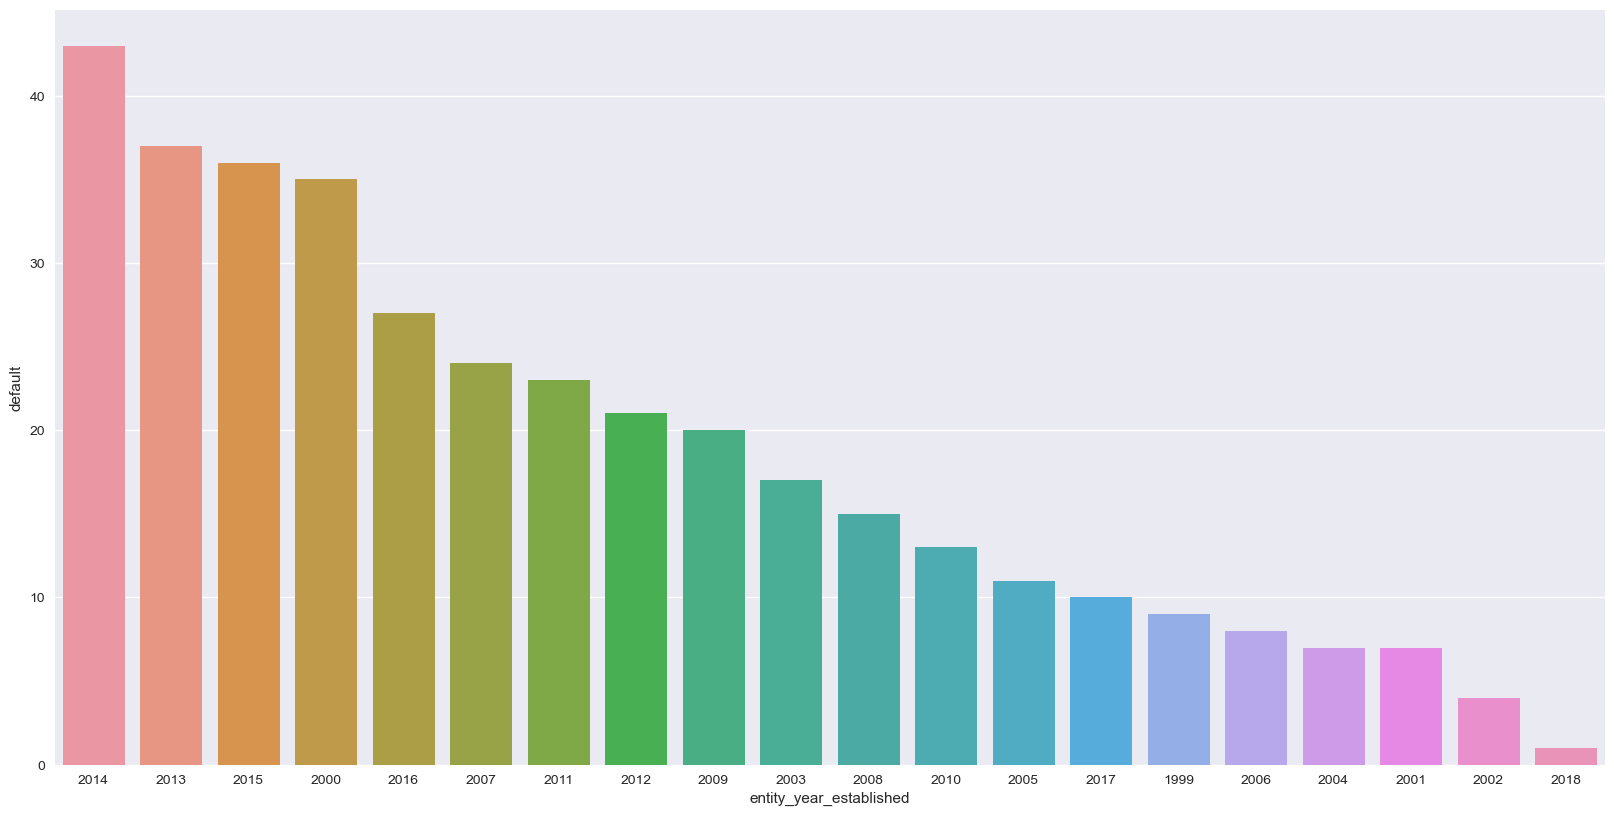

In [74]:
# sns.barplot(x=year_default.entity_year_established, y=year_default.default, order=year_default.default)
# sns.barplot(data=year_default, x="entity_year_established", y="default_pct", order=entity_default_rate['entity_year_established'])
sns.barplot(data=year_default, x="entity_year_established", y="default", order=year_default['entity_year_established'])


In [75]:
px.pie(year_default, values="default", names=year_default.entity_year_established, width=700)

##### Default Year that carries the most liability

In [76]:
year_default_liability = default_status[(default_status.payment_code == False)]
year_default_liability = pd.merge(year_default_liability, default_amount, on=["client_id", "entity_type", "entity_year_established"])
year_default_liability

,client_id,entity_type,entity_year_established,payment_code,default_amt
0,7,Australian Private Company,2015,False,1649.99
1,11,Australian Private Company,1999,False,2320.00
2,21,Individual/Sole Trader,1999,False,950.00
3,24,Individual/Sole Trader,2016,False,191.67
4,25,Australian Private Company,2016,False,5509.97
...,...,...,...,...,...
363,1241,Australian Private Company,2016,False,1778.33
364,1245,Family Partnership,2015,False,1933.33
365,1247,Australian Private Company,2009,False,1705.00
366,1252,Australian Private Company,2014,False,4329.16


In [77]:
entity_default_liability

,client_id,liability
0,1,9016.68
1,2,25950.03
2,3,4261.68
3,4,8016.56
4,5,5211.69
...,...,...
1282,1277,21731.73
1283,1278,9999.98
1284,1279,108658.32
1285,1280,21731.73


In [78]:
default_status

,client_id,entity_type,entity_year_established,payment_code
0,1,Other Partnership,2006,True
1,2,Australian Private Company,2001,True
2,3,Australian Private Company,2002,True
3,4,Australian Private Company,2007,True
4,5,Australian Private Company,2007,True
...,...,...,...,...
1282,1277,Individual/Sole Trader,2004,True
1283,1278,Fixed Unit Trust,2007,True
1284,1279,Discretionary Trading Trust,2017,True
1285,1280,Australian Private Company,2016,True


In [79]:
# year_default_liability = pd.merge(default_status, entity_default_liability,on="client_id")
# year_default_liability = year_default_liability[year_default_liability.payment_code == False]
# year_default_liability = year_default_liability.groupby("entity_year_established").liability.sum().reset_index()
# year_default_liability.sort_values(by="liability", ascending=False)

In [80]:
year_default_liability

,client_id,entity_type,entity_year_established,payment_code,default_amt
0,7,Australian Private Company,2015,False,1649.99
1,11,Australian Private Company,1999,False,2320.00
2,21,Individual/Sole Trader,1999,False,950.00
3,24,Individual/Sole Trader,2016,False,191.67
4,25,Australian Private Company,2016,False,5509.97
...,...,...,...,...,...
363,1241,Australian Private Company,2016,False,1778.33
364,1245,Family Partnership,2015,False,1933.33
365,1247,Australian Private Company,2009,False,1705.00
366,1252,Australian Private Company,2014,False,4329.16


In [81]:
df[(df.entity_year_established == 2018) & (df.payment_code == False)].payment_amt.sum()

950.24

In [82]:
px.pie(year_default_liability, values="default_amt", names=year_default_liability.entity_year_established, width=700)

In [83]:
year_default_liability = year_default_liability.groupby(["entity_year_established"]).default_amt.sum().reset_index()
year_default_liability.sort_values(by="default_amt", ascending=False)

,entity_year_established,default_amt
16,2015,242638.05
1,2000,195179.71
15,2014,179505.71
14,2013,98676.64
4,2003,90321.84
12,2011,88367.05
8,2007,88292.29
13,2012,79167.33
10,2009,72226.85
17,2016,60423.81


In [84]:
group_year_default = pd.merge(year_default, year_default_liability, on="entity_year_established")
group_year_default

,entity_year_established,default,default_amt
0,2014,43,179505.71
1,2013,37,98676.64
2,2015,36,242638.05
3,2000,35,195179.71
4,2016,27,60423.81
5,2007,24,88292.29
6,2011,23,88367.05
7,2012,21,79167.33
8,2009,20,72226.85
9,2003,17,90321.84


# 3. Feature Engineering

##### Number of Companies Owned by A Client (df: client_company_info)

In [85]:
default_status.iloc[:, :2]

,client_id,entity_type
0,1,Other Partnership
1,2,Australian Private Company
2,3,Australian Private Company
3,4,Australian Private Company
4,5,Australian Private Company
...,...,...
1282,1277,Individual/Sole Trader
1283,1278,Fixed Unit Trust
1284,1279,Discretionary Trading Trust
1285,1280,Australian Private Company


In [86]:
client_company_info = default_status.iloc[:, :2].pivot_table(index=['client_id'], aggfunc=[len], columns=['entity_type'], fill_value=0)
client_company_info.columns = client_company_info.columns.droplevel(0) #remove amount
client_company_info.columns.name = None               #remove categories
client_company_info = client_company_info.reset_index()
client_company_info

,client_id,Australian Private Company,Australian Proprietary Company,Australian Public Company,Discretionary Investment Trust,Discretionary Trading Trust,Family Partnership,Fixed Unit Trust,Hybrid Trust,Individual/Sole Trader,Other Partnership
0,1,0,0,0,0,0,0,0,0,0,1
1,2,1,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1276,1277,0,0,0,0,0,0,0,0,1,0
1277,1278,0,0,0,0,0,0,1,0,0,0
1278,1279,0,0,0,0,1,0,0,0,0,0
1279,1280,1,0,0,0,0,0,0,0,0,0


In [87]:
default_status

,client_id,entity_type,entity_year_established,payment_code
0,1,Other Partnership,2006,True
1,2,Australian Private Company,2001,True
2,3,Australian Private Company,2002,True
3,4,Australian Private Company,2007,True
4,5,Australian Private Company,2007,True
...,...,...,...,...
1282,1277,Individual/Sole Trader,2004,True
1283,1278,Fixed Unit Trust,2007,True
1284,1279,Discretionary Trading Trust,2017,True
1285,1280,Australian Private Company,2016,True


In [88]:
default_status.iloc[:, 0:3:2]

,client_id,entity_year_established
0,1,2006
1,2,2001
2,3,2002
3,4,2007
4,5,2007
...,...,...
1282,1277,2004
1283,1278,2007
1284,1279,2017
1285,1280,2016


In [89]:
client_year_info = default_status.iloc[:, 0:3:2].pivot_table(index=['client_id'], aggfunc=[len], columns=['entity_year_established'], fill_value=0)
client_year_info.columns = client_year_info.columns.droplevel(0) #remove amount
client_year_info.columns.name = None               #remove categories
client_year_info = client_year_info.reset_index()
client_year_info.columns = client_year_info.columns.astype(str)
client_year_info.columns

Index(['client_id', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018'],
      dtype='object')

##### Number of Contracts by a Client (df: n_contracts)

In [90]:
n_contracts = df.groupby(["client_id"]).contract_id.nunique().reset_index()
n_contracts

,client_id,contract_id
0,1,1
1,2,1
2,3,2
3,4,1
4,5,1
...,...,...
1276,1277,1
1277,1278,1
1278,1279,1
1279,1280,1


##### Average Transaction/Payment Interval (df: avg_txn_interval)

In [91]:
transaction = df.groupby(["client_id", "transaction_date"]).payment_amt.mean().reset_index()
transaction

,client_id,transaction_date,payment_amt
0,1,2017-11-22,2550.020
1,1,2017-11-26,266.665
2,1,2017-12-21,241.665
3,1,2018-02-22,241.665
4,1,2018-03-22,241.665
...,...,...,...
12971,1279,2018-07-17,49999.990
12972,1279,2018-07-22,4329.170
12973,1280,2018-07-16,10000.030
12974,1280,2018-07-19,865.835


In [92]:
# avg_txn_interval = df[df.client_id == 1278].sort_values(by="transaction_date")
# avg_txn_interval = df.groupby(["client_id", "transaction_date"]).payment_amt.sum().reset_index()
# avg_txn_interval

In [93]:
avg_txn_interval = df.groupby(["client_id", "transaction_date"]).payment_amt.sum().reset_index()
avg_txn_interval['previous_schedule'] = avg_txn_interval.groupby(['client_id'])['transaction_date'].shift()
avg_txn_interval['next_schedule'] = avg_txn_interval['transaction_date'] - avg_txn_interval['previous_schedule']
avg_txn_interval['next_schedule'] = avg_txn_interval['next_schedule'].apply(lambda x: x.days)
avg_txn_interval = avg_txn_interval.groupby('client_id')['next_schedule'].agg('mean').reset_index().fillna(0)
avg_txn_interval.rename(columns={"next_schedule" : "avg_txn_interval"}, inplace=True)
avg_txn_interval

,client_id,avg_txn_interval
0,1,30.250000
1,2,21.000000
2,3,39.222222
3,4,27.300000
4,5,25.000000
...,...,...
1276,1277,3.000000
1277,1278,0.000000
1278,1279,5.000000
1279,1280,3.000000


##### Effects of Payment Intervals for Clients Analysis

In [94]:
avg_txn_interval_default = pd.merge(avg_txn_interval, default_status_list, on="client_id")
avg_txn_interval_default

,client_id,avg_txn_interval,payment_code
0,1,30.250000,True
1,2,21.000000,True
2,3,39.222222,True
3,4,27.300000,True
4,5,25.000000,True
...,...,...,...
1282,1277,3.000000,True
1283,1278,0.000000,True
1284,1279,5.000000,True
1285,1280,3.000000,True


In [95]:
avg_txn_interval_default_clean = removeOutlier(avg_txn_interval_default, "avg_txn_interval")


([<matplotlib.axis.XTick at 0x220577f2790>,
 [Text(0, 0, 'Default'), Text(1, 0, 'Payment')])

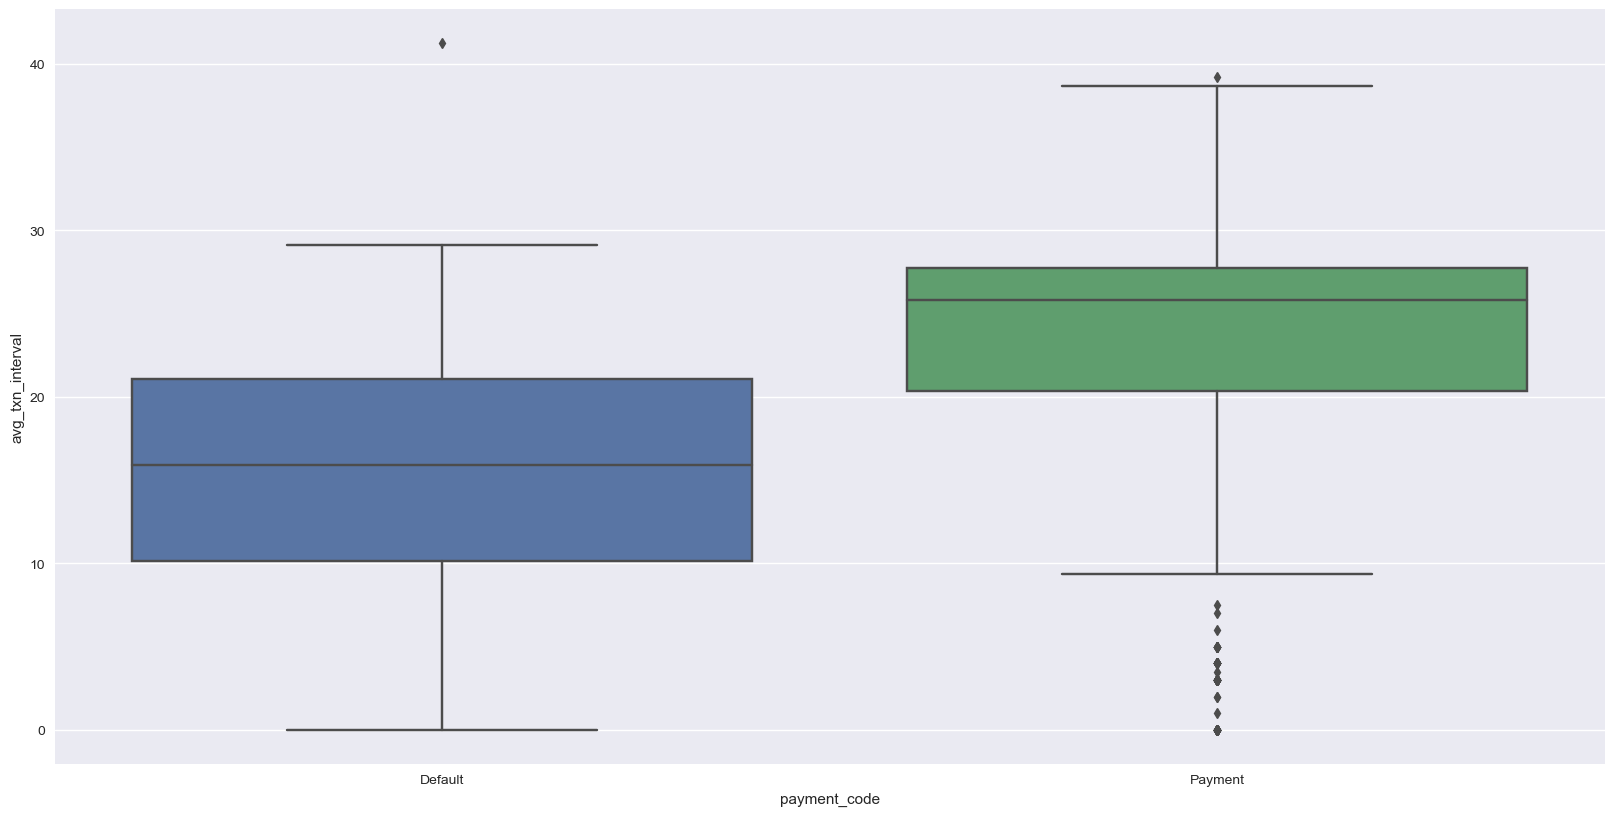

In [96]:
sns.boxplot(x="payment_code", y="avg_txn_interval", data=avg_txn_interval_default_clean)
plt.xticks([0, 1], ["Default", "Payment"])

In [97]:
avg_txn_interval_default_clean[avg_txn_interval_default_clean.payment_code == True].describe()


,client_id,avg_txn_interval
count,917.000000,917.000000
mean,653.988004,22.447979
std,380.355552,8.851433
min,1.000000,0.000000
25%,317.000000,20.333333
50%,651.000000,25.846154
75%,991.000000,27.727273
max,1281.000000,39.222222


In [98]:
avg_txn_interval_default_clean[avg_txn_interval_default_clean.payment_code == False].median()


client_id           594.000000
avg_txn_interval     15.916667
payment_code          0.000000
dtype: float64

The intervals of payment may have some effects on the default probability of a client

### Final Merged DataFrame

total_liability is also a feature we want

In [99]:
df_default = pd.merge(avg_txn_interval, client_company_info, on="client_id")

In [100]:
df_default = pd.merge(df_default, n_contracts, on="client_id")
# df_default = pd.merge(df_default, clients[["client_id", "entity_year_established"]], on="client_id")
df_default = pd.merge(df_default, client_year_info, on="client_id")

df_default = pd.merge(df_default, total_liability, on="client_id")

df_default

,client_id,avg_txn_interval,Australian Private Company,Australian Proprietary Company,Australian Public Company,Discretionary Investment Trust,Discretionary Trading Trust,Family Partnership,Fixed Unit Trust,Hybrid Trust,...,2011,2012,2013,2014,2015,2016,2017,2018,payment_amt,payment_code
0,1,30.250000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9016.68,True
1,2,21.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25950.03,True
2,3,39.222222,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4261.68,True
3,4,27.300000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8016.56,True
4,5,25.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5211.69,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,1277,3.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21731.73,True
1277,1278,0.000000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,9999.98,True
1278,1279,5.000000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,108658.32,True
1279,1280,3.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,21731.73,True


In [119]:
df_default.columns

Index(['client_id', 'avg_txn_interval', 'Australian Private Company',
       'Australian Proprietary Company', 'Australian Public Company',
       'Discretionary Investment Trust', 'Discretionary Trading Trust',
       'Family Partnership', 'Fixed Unit Trust', 'Hybrid Trust',
       'Individual/Sole Trader', 'Other Partnership', 'contract_id', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', 'payment_amt', 'payment_code'],
      dtype='object')

In [120]:
df.columns

Index(['transaction_id', 'contract_id', 'client_id', 'transaction_date',
       'payment_amt', 'payment_code', 'entity_type',
       'entity_year_established'],
      dtype='object')

# 4. Modeling

In [102]:
from sklearn          import tree
from xgboost          import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree     import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics         import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

d:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [440]:
df_default

,client_id,avg_txn_interval,Australian Private Company,Australian Proprietary Company,Australian Public Company,Discretionary Investment Trust,Discretionary Trading Trust,Family Partnership,Fixed Unit Trust,Hybrid Trust,...,2011,2012,2013,2014,2015,2016,2017,2018,payment_amt,payment_code
0,1,30.250000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9016.68,True
1,2,21.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25950.03,True
2,3,39.222222,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4261.68,True
3,4,27.300000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8016.56,True
4,5,25.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5211.69,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,1277,3.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,21731.73,True
1277,1278,0.000000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,9999.98,True
1278,1279,5.000000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,108658.32,True
1279,1280,3.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,21731.73,True


In [439]:
X = df_default.iloc[:, 1:-1]
y = df_default.iloc[:, -1].map({True:0, False:1})

In [441]:
X.drop("contract_id", axis=1, inplace=True)

In [442]:
X.shape

(1281, 32)

In [105]:
y.shape

(1281,)

In [106]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'binary'

In [444]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, stratify=y)

In [445]:
X_train

,avg_txn_interval,Australian Private Company,Australian Proprietary Company,Australian Public Company,Discretionary Investment Trust,Discretionary Trading Trust,Family Partnership,Fixed Unit Trust,Hybrid Trust,Individual/Sole Trader,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,payment_amt
989,15.000000,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,24016.70
1182,3.000000,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5633.37
1069,25.090909,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,10844.07
180,3.000000,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,22083.37
465,30.285714,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15066.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,15.000000,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,35950.00
266,0.000000,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,282.50
73,27.916667,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,17430.00
187,27.916667,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,15269.88


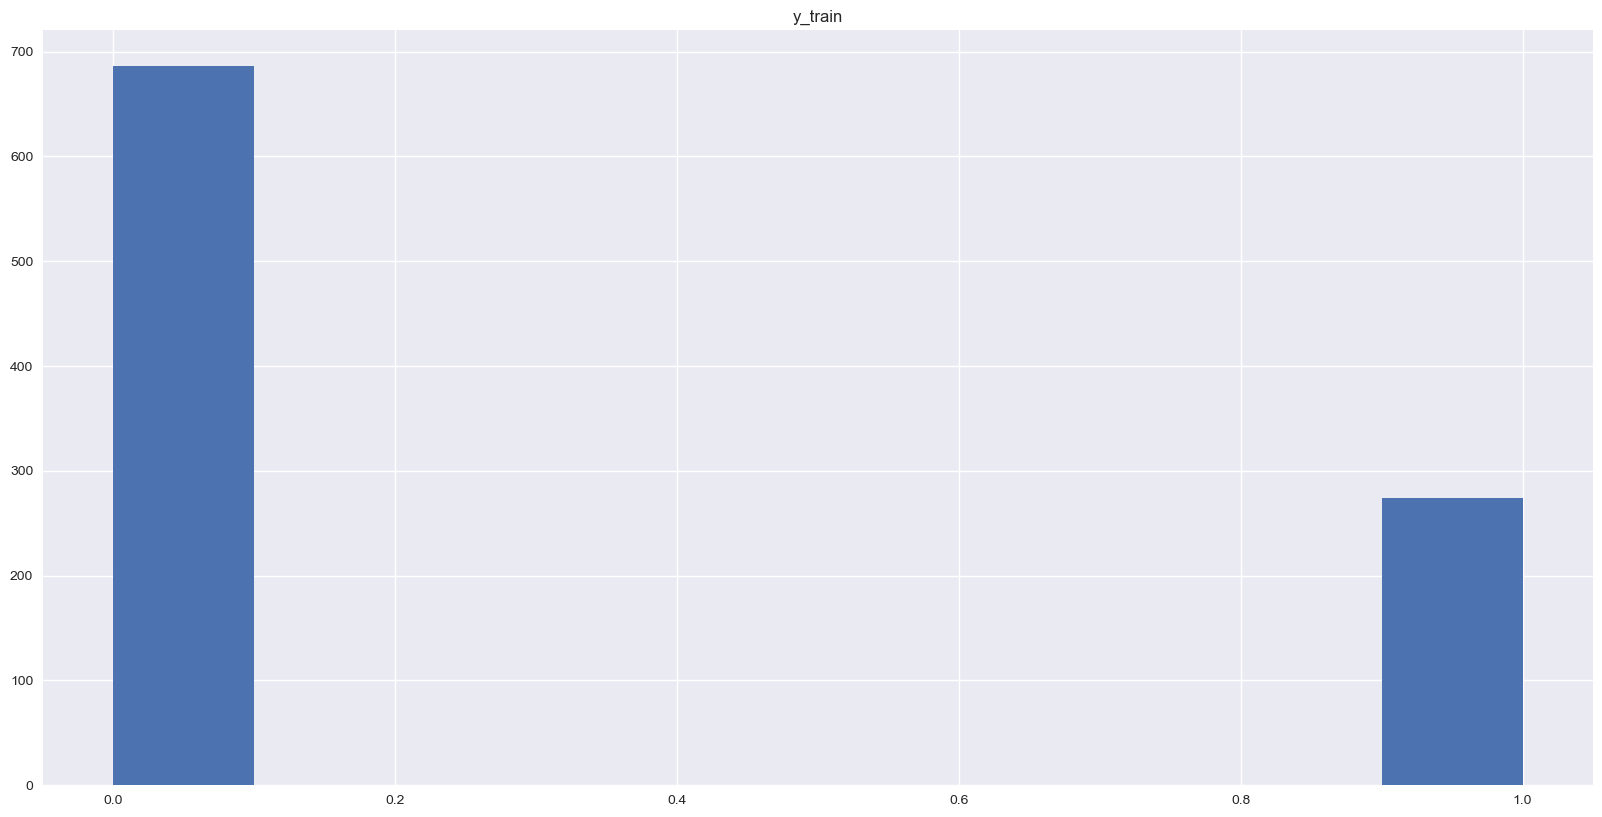

In [446]:
y_train.hist()
plt.title("y_train")
plt.show()

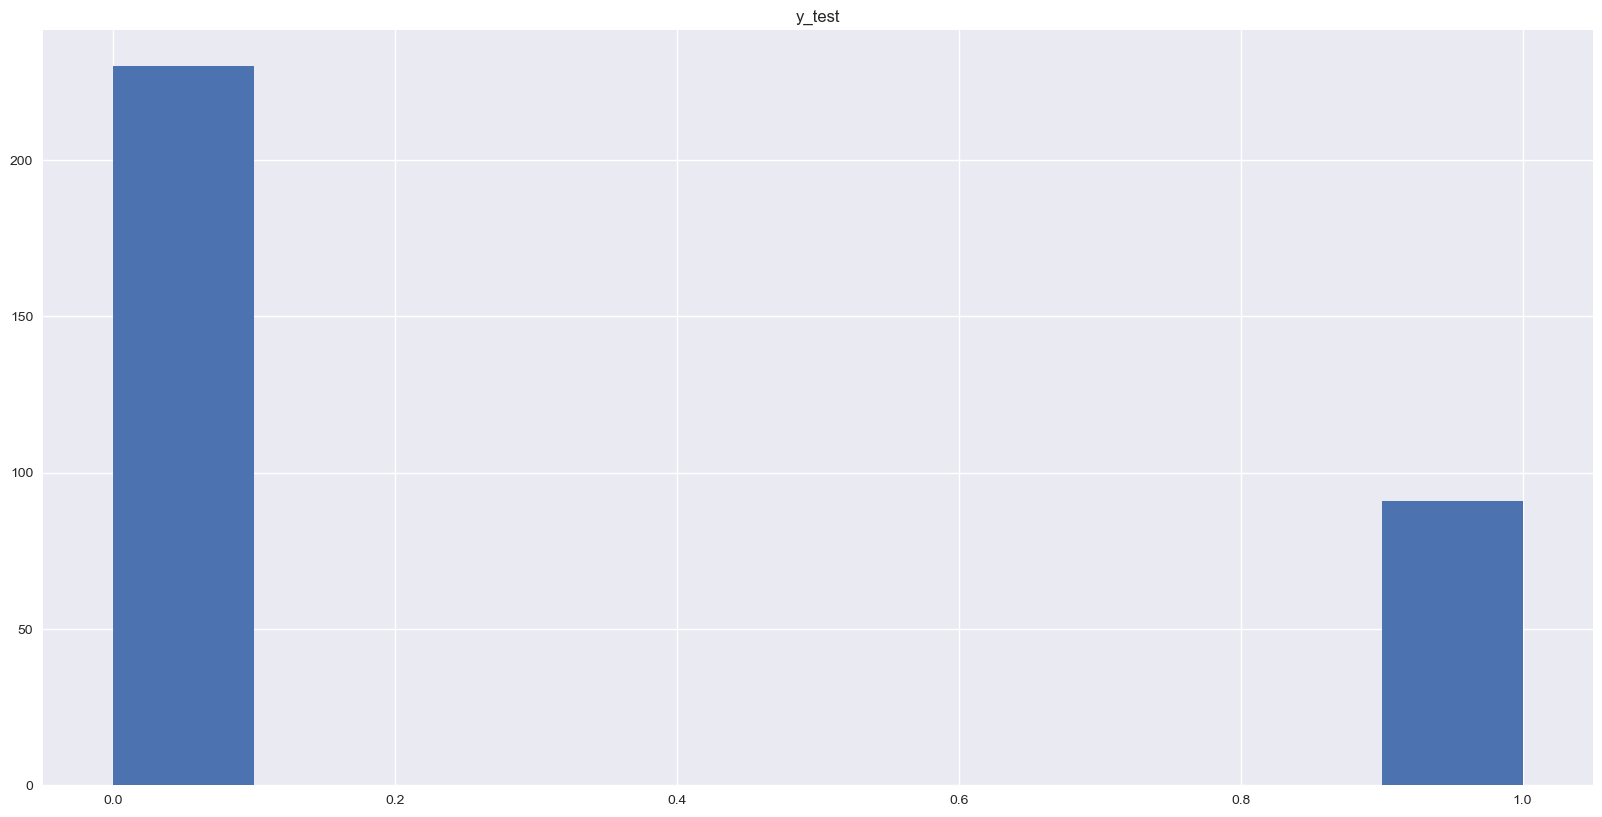

In [447]:
y_test.hist()
plt.title("y_test")
plt.show()

### DTree

In [456]:
tree_params = {
    'max_leaf_nodes': np.arange(2, 10), 
    'min_samples_split': [2, 3, 4],
    'max_depth': [2,3,4],
    'criterion':['gini','entropy'],
    'max_features': np.arange(1,11)
}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

tree_clf = DecisionTreeClassifier()

tree_random_search = RandomizedSearchCV(tree_clf, param_distributions=tree_params, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train, y_train), verbose=0, random_state=0)

tree_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000220615B2BA0>,
                   estimator=DecisionTreeClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4],
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': [2, 3, 4]},
                   random_state=0, scoring='roc_auc')

In [457]:
tree_random_search.best_estimator_.feature_importances_

array([0.78652564, 0.0416361 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04187717, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05422086, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07574023])

In [458]:
score = cross_val_score(tree_random_search.best_estimator_, X_test, y_test, cv=skf, verbose=0)
score.mean()

0.7258653846153846

In [459]:
[(feature, importance) for feature, importance, in zip(X.columns, tree_random_search.best_estimator_.feature_importances_)]

[('avg_txn_interval', 0.7865256357476785),
 ('Australian Private Company', 0.04163610069316836),
 ('Australian Proprietary Company', 0.0),
 ('Australian Public Company', 0.0),
 ('Discretionary Investment Trust', 0.0),
 ('Discretionary Trading Trust', 0.0),
 ('Family Partnership', 0.0),
 ('Fixed Unit Trust', 0.0),
 ('Hybrid Trust', 0.0),
 ('Individual/Sole Trader', 0.0),
 ('Other Partnership', 0.0),
 ('1999', 0.0),
 ('2000', 0.0),
 ('2001', 0.0),
 ('2002', 0.0),
 ('2003', 0.0),
 ('2004', 0.0),
 ('2005', 0.0),
 ('2006', 0.04187717215794396),
 ('2007', 0.0),
 ('2008', 0.0),
 ('2009', 0.0),
 ('2010', 0.0),
 ('2011', 0.0),
 ('2012', 0.0),
 ('2013', 0.05422085709642295),
 ('2014', 0.0),
 ('2015', 0.0),
 ('2016', 0.0),
 ('2017', 0.0),
 ('2018', 0.0),
 ('payment_amt', 0.07574023430478628)]

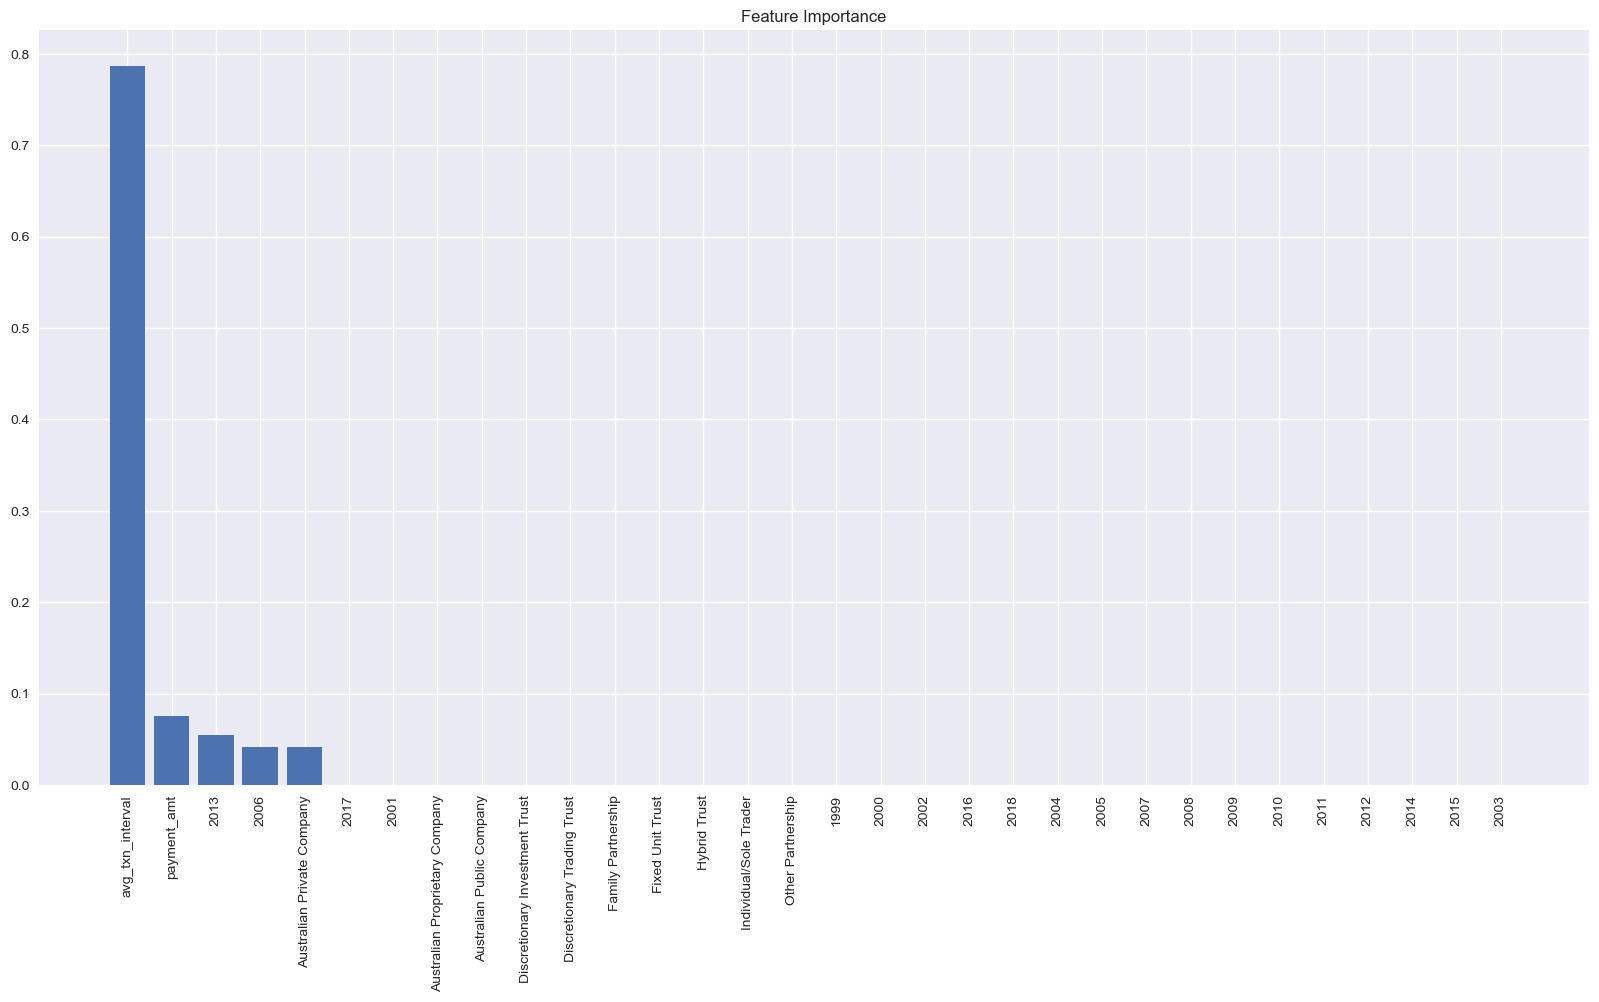

In [460]:
# Calculate feature importances
importances = tree_random_search.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

names = [X.columns[i] for i in indices]

# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# Show plot
plt.show()

Precision and Recall

In [453]:
tree_random_search.best_estimator_.fit(X_train, y_train)

y_pred = tree_random_search.best_estimator_.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"]))

              precision    recall  f1-score   support

     PAYMENT       0.89      0.73      0.80       230
     DEFAULT       0.53      0.77      0.63        91

    accuracy                           0.74       321
   macro avg       0.71      0.75      0.72       321
weighted avg       0.79      0.74      0.76       321



In [454]:
def dtree_recall_score(X_train, y_train):
    score = []
    for x in np.arange(1,6):
        tree_random_search.best_estimator_.fit(X_train, y_train)
        y_pred = tree_random_search.best_estimator_.predict(X_test)
        score.append(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"], output_dict=True)["DEFAULT"]["recall"])
    print(np.array(score).mean())

In [455]:
dtree_recall_score(X_train, y_train)

0.36703296703296706


In [317]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred)) # print classification report
    # return accuracy_score(y_true, y_pred) # return accuracy score
    return classification_report(y_true, y_pred, target_names=["PAYMENT", "DEFAULT"], output_dict=True)["DEFAULT"]["recall"]

nested_score = cross_val_score(tree_random_search.best_estimator_, X_test, y_test, cv=skf, verbose=0,
               scoring=make_scorer(classification_report_with_accuracy_score))
print( nested_score.mean() )

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        46
           1       0.44      0.37      0.40        19

    accuracy                           0.68        65
   macro avg       0.60      0.59      0.59        65
weighted avg       0.66      0.68      0.67        65

              precision    recall  f1-score   support

           0       0.72      0.91      0.81        46
           1       0.33      0.11      0.17        18

    accuracy                           0.69        64
   macro avg       0.53      0.51      0.49        64
weighted avg       0.61      0.69      0.63        64

              precision    recall  f1-score   support

           0       0.93      0.59      0.72        46
           1       0.46      0.89      0.60        18

    accuracy                           0.67        64
   macro avg       0.69      0.74      0.66        64
weighted avg       0.80      0.67      0.69        64

              preci

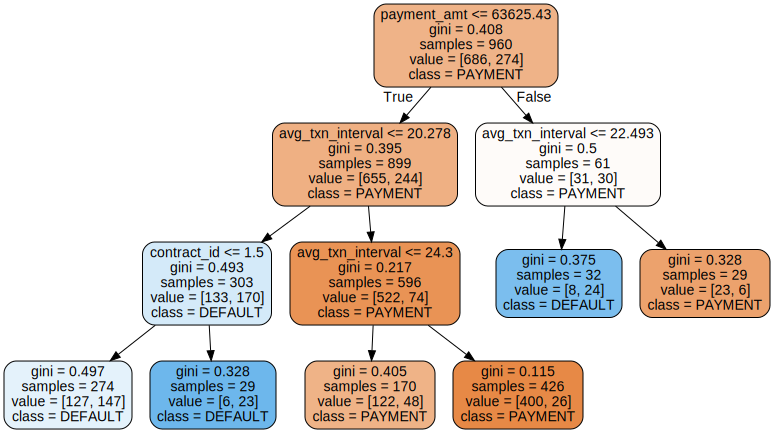

In [215]:
import graphviz
data = tree.export_graphviz(
    tree_random_search.best_estimator_,
    feature_names=X.columns,
    class_names=["PAYMENT", "DEFAULT"],
    rounded=True,
    filled=True
)
graphviz.Source(data)

### Random Forest

In [461]:
param_grid = { 
    'n_estimators': [1000, 3000, 5000, 7000, 10000, 20000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(2,8),
    # 'criterion' :['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [462]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

In [463]:
rfc = RandomForestClassifier()

In [464]:
# rfcSearch = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= skf, n_jobs=-1)
rfc_random_search = RandomizedSearchCV(rfc, param_distributions=param_grid, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train, y_train), verbose=0, random_state=0)

In [465]:
rfc_random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000022063399DD0>,
                   estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1000, 3000, 5000, 7000,
                                                         10000, 20000]},
                   random_state=0, scoring='roc_auc')

Param Search Results

In [466]:
rfc_random_search.best_estimator_

RandomForestClassifier(max_depth=7, max_features='log2', min_samples_split=5,
                       n_estimators=1000)

In [467]:
rfc_random_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 7,
 'bootstrap': True}

##### StratifiedKFold Cross Val Score

In [393]:
score = cross_val_score(rfc_random_search.best_estimator_, X_test, y_test, cv=skf, verbose=0)

In [394]:
score.mean()

0.775625

##### Feature Importance Ranking

In [468]:
[(feature, importance) for feature, importance, in zip(X.columns, rfc_random_search.best_estimator_.feature_importances_)]

[('avg_txn_interval', 0.626144846908978),
 ('Australian Private Company', 0.02050422733027262),
 ('Australian Proprietary Company', 0.0006902836101427853),
 ('Australian Public Company', 0.007335170274808447),
 ('Discretionary Investment Trust', 0.004069382154516733),
 ('Discretionary Trading Trust', 0.0062097321325763994),
 ('Family Partnership', 0.007182774924497059),
 ('Fixed Unit Trust', 0.002320559850595488),
 ('Hybrid Trust', 0.005169828854873459),
 ('Individual/Sole Trader', 0.017869624897890894),
 ('Other Partnership', 0.0028612011116804933),
 ('1999', 0.005305713799585679),
 ('2000', 0.008502010706942566),
 ('2001', 0.005320324542099866),
 ('2002', 0.005142147558396394),
 ('2003', 0.006741241182486079),
 ('2004', 0.005213733484282736),
 ('2005', 0.004328979835069845),
 ('2006', 0.00941745411628568),
 ('2007', 0.008083052152254631),
 ('2008', 0.00235662733370143),
 ('2009', 0.010224064253145754),
 ('2010', 0.0044805546297720135),
 ('2011', 0.009376668980062182),
 ('2012', 0.005

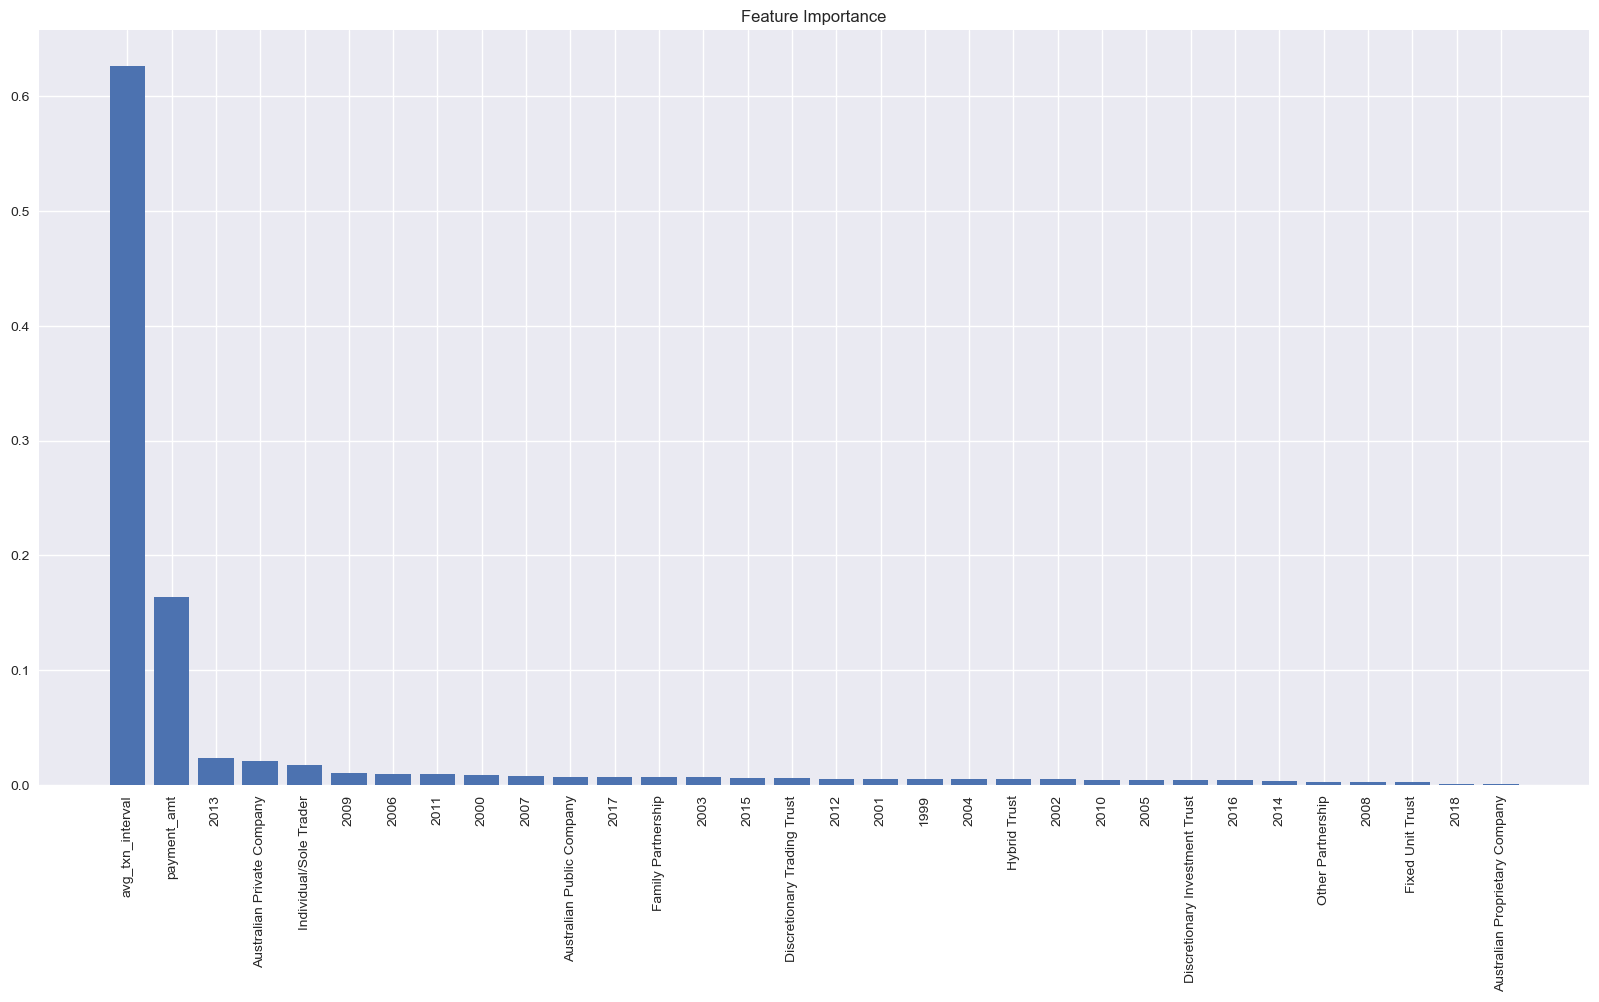

In [469]:
# Calculate feature importances
importances = rfc_random_search.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

names = [X.columns[i] for i in indices]

# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# Show plot
plt.show()

##### Precision and Recall

In [470]:
rfc_random_search.best_estimator_.fit(X_train, y_train)

y_pred = rfc_random_search.best_estimator_.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"]))

              precision    recall  f1-score   support

     PAYMENT       0.84      0.93      0.88       230
     DEFAULT       0.75      0.54      0.63        91

    accuracy                           0.82       321
   macro avg       0.79      0.73      0.75       321
weighted avg       0.81      0.82      0.81       321



In [487]:
def rforest_recall_score(X_train, y_train):
    score = []
    for x in np.arange(1,6):
        rfc_random_search.best_estimator_.fit(X_train, y_train)
        y_pred = rfc_random_search.best_estimator_.predict(X_test)
        score.append(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"], output_dict=True)["DEFAULT"]["recall"])
    print(np.array(score).mean())
rforest_recall_score(X_train, y_train)

0.5736263736263736


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

nested_score = cross_val_score(rfc_random_search.best_estimator_, X, y, cv=skf, verbose=0,
               scoring=make_scorer(classification_report_with_accuracy_score))
print( nested_score.mean() )

              precision    recall  f1-score   support

       False       0.67      0.03      0.05        73
        True       0.72      0.99      0.84       184

    accuracy                           0.72       257
   macro avg       0.69      0.51      0.44       257
weighted avg       0.71      0.72      0.61       257

              precision    recall  f1-score   support

       False       0.57      0.05      0.10        73
        True       0.72      0.98      0.83       183

    accuracy                           0.72       256
   macro avg       0.65      0.52      0.47       256
weighted avg       0.68      0.72      0.62       256

              precision    recall  f1-score   support

       False       0.33      0.04      0.07        73
        True       0.72      0.97      0.82       183

    accuracy                           0.70       256
   macro avg       0.52      0.50      0.45       256
weighted avg       0.61      0.70      0.61       256

              preci

In [ ]:
y.value_counts()

0    916
1    365
Name: payment_code, dtype: int64

### XGBoost

In [472]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

In [473]:
from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

In [474]:
params = {
    'max_depth':        [3, 4, 5, 6, 7],
    'min_child_weight': np.arange(1, 11),
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': np.arange(0.01, 0.11, 0.01),
    'gamma':            [0.5, 1, 1.5, 2, 3, 4, 5],
    'n_estimators':     [1000, 3000, 5000, 7000, 10000, 20000],
    'learning_rate':    np.arange(0.01, 0.1, 0.02),
    'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 200, 300, 1000]
}

xgb = XGBClassifier(nthread=8, 
                    use_label_encoder=False,
                    # eval_metric='binary:logistic',
                    error_score='raise',
                    )

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train, y_train), verbose=0, random_state=0)

In [475]:
random_search.fit(X_train, y_train)

[09:16:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:16:47] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002205EDC5CF0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           error_score='raise', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=No...
                   param_distributions={'colsample_bytree': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'gamma': [0.5, 1, 1.5, 2, 3, 4, 5],
                                        'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': [1000, 3000, 5000, 7000,
                                                         10000, 20000],
                                        'scale_pos_weight': [1, 10, 25, 50, 75,
                                                             99, 100, 200, 300,
                                                             1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=0, scoring='roc_auc')

In [476]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.03,
              enable_categorical=False, error_score='raise', gamma=3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.06999999999999999, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=8, nthread=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=75, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [477]:
random_search.best_params_

{'subsample': 0.6,
 'scale_pos_weight': 75,
 'n_estimators': 5000,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning_rate': 0.06999999999999999,
 'gamma': 3,
 'colsample_bytree': 0.03}

##### StratifiedKFold Cross Val Score

In [478]:
score = cross_val_score(random_search.best_estimator_, X_test, y_test, cv=5, verbose=0)
score.mean()

[09:16:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:16:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:16:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used


0.791201923076923

##### Feature Importance Ranking

In [486]:
[(feature, importance) for feature, importance, in zip(X.columns, random_search.best_estimator_.feature_importances_)]

[('avg_txn_interval', 0.10088337),
 ('Australian Private Company', 0.042776834),
 ('Australian Proprietary Company', 0.0),
 ('Australian Public Company', 0.019430462),
 ('Discretionary Investment Trust', 0.0),
 ('Discretionary Trading Trust', 0.0),
 ('Family Partnership', 0.0513303),
 ('Fixed Unit Trust', 0.0),
 ('Hybrid Trust', 0.02447289),
 ('Individual/Sole Trader', 0.0302523),
 ('Other Partnership', 0.020320358),
 ('1999', 0.03291068),
 ('2000', 0.040190224),
 ('2001', 0.03322594),
 ('2002', 0.040595666),
 ('2003', 0.033629227),
 ('2004', 0.028578317),
 ('2005', 0.0331531),
 ('2006', 0.04396853),
 ('2007', 0.026339017),
 ('2008', 0.044887826),
 ('2009', 0.034039237),
 ('2010', 0.038811717),
 ('2011', 0.026542999),
 ('2012', 0.03242411),
 ('2013', 0.028346922),
 ('2014', 0.034037016),
 ('2015', 0.043330733),
 ('2016', 0.03546328),
 ('2017', 0.029261861),
 ('2018', 0.0),
 ('payment_amt', 0.05079707)]

In [480]:
X.columns

Index(['avg_txn_interval', 'Australian Private Company',
       'Australian Proprietary Company', 'Australian Public Company',
       'Discretionary Investment Trust', 'Discretionary Trading Trust',
       'Family Partnership', 'Fixed Unit Trust', 'Hybrid Trust',
       'Individual/Sole Trader', 'Other Partnership', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       'payment_amt'],
      dtype='object')

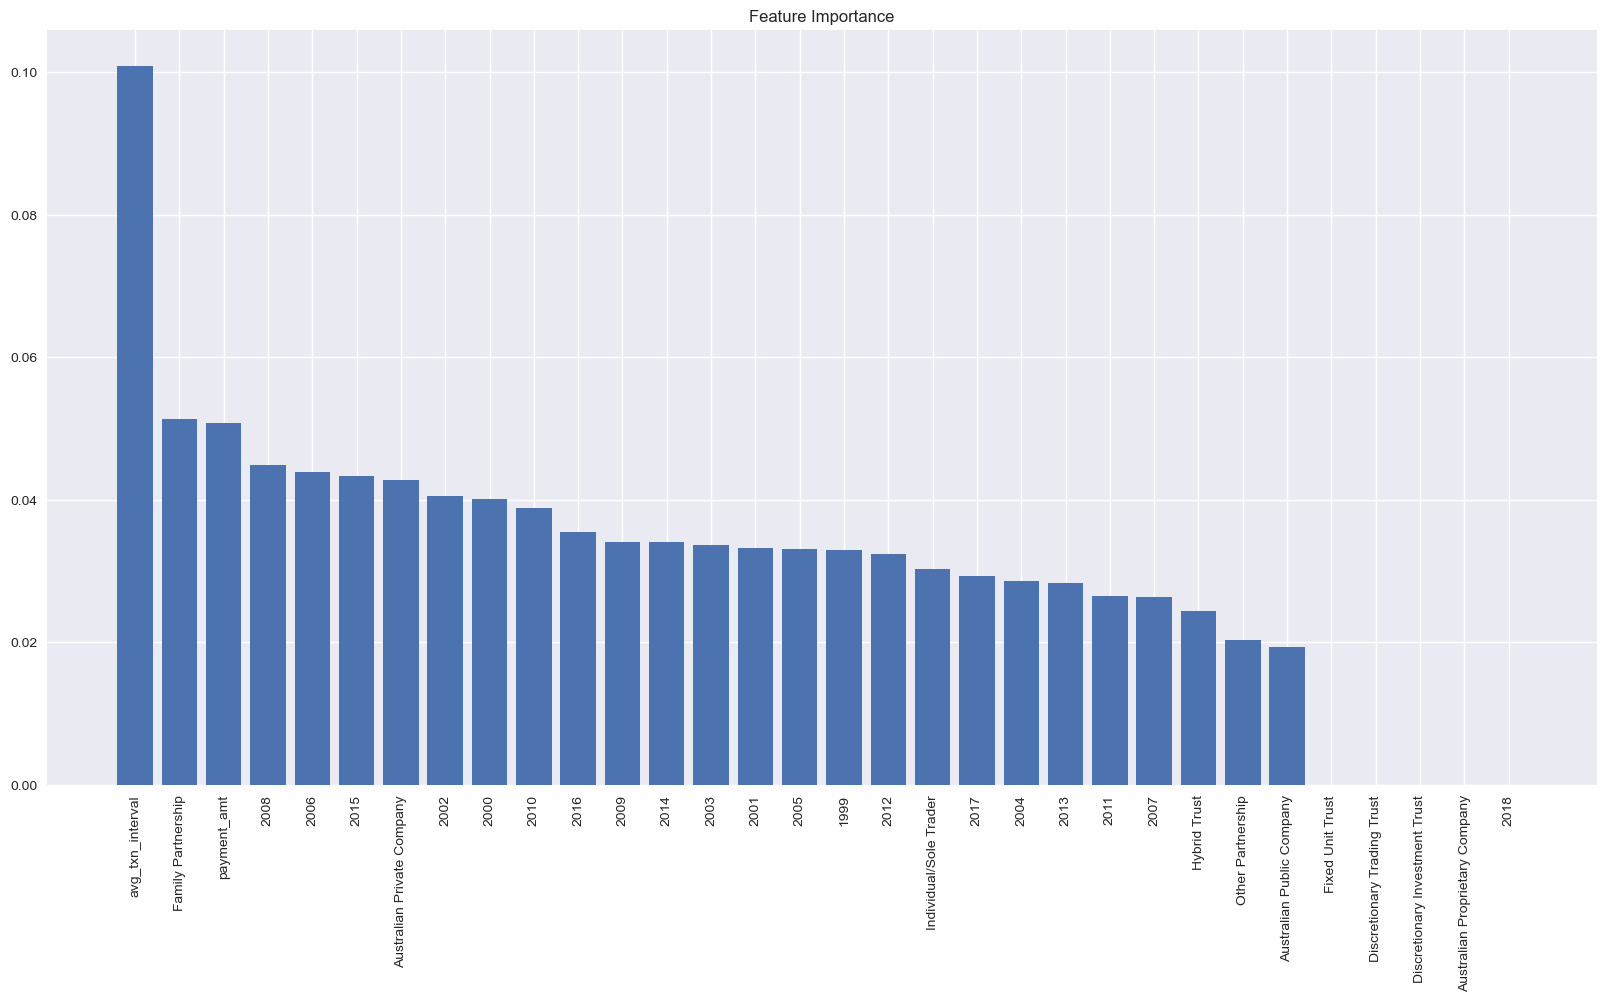

In [485]:
# Calculate feature importances
importances = random_search.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

names = [X.columns[i] for i in indices]

# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# Show plot
plt.show()

##### Precision and Recall

In [482]:
def xgboost_recall_score(X_train, y_train):
    score = []
    for x in np.arange(1,6):
        random_search.best_estimator_.fit(X_train, y_train)
        y_pred = random_search.best_estimator_.predict(X_test)
        score.append(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"], output_dict=True)["DEFAULT"]["recall"])
    print(np.array(score).mean())
xgboost_recall_score(X_train, y_train)

[09:16:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:16:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:16:57] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used


In [484]:
random_search.best_estimator_.fit(X_train, y_train)

y_pred = random_search.best_estimator_.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"]))

[09:18:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

     PAYMENT       0.98      0.76      0.85       230
     DEFAULT       0.61      0.96      0.74        91

    accuracy                           0.81       321
   macro avg       0.79      0.86      0.80       321
weighted avg       0.87      0.81      0

In [238]:
new = classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"], output_dict=True)["DEFAULT"]["recall"]
new

0.967032967032967

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, accuracy_score, make_scorer, recall_score, precision_score
recall_score = []

def classification_report_with_accuracy_score(y_true, y_pred):
    # print (classification_report(y_true, y_pred)) # print classification report
    # print (classification_report(y_test, y_pred)) # print classification report

    print (classification_report(y_true, y_pred, target_names=["PAYMENT", "DEFAULT"])) # print classification report
    # recall_score.append(default_recall)
    # return accuracy_score(y_true, y_pred) # return accuracy score
    return classification_report(y_true, y_pred, target_names=["PAYMENT", "DEFAULT"], output_dict=True)["DEFAULT"]["recall"]

nested_score = cross_val_score(random_search.best_estimator_, X, y, cv=skf, verbose=0,
               scoring=make_scorer(classification_report_with_accuracy_score))
print( nested_score.mean() )

[13:41:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "error_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:41:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

     PAYMENT       0.94      0.75      0.83       184
     DEFAULT       0.58      0.88      0.70        73

    accuracy                           0.79       257
   macro avg       0.76      0.81      0.77       257
weighted avg       0.84      0.79      0

In [ ]:
nested_score.std()

0.06548405940310806

In [ ]:
recall_score

[]

In [ ]:
default_status[default_status.client_id == 591]

,client_id,entity_type,entity_year_established,payment_code
594,591,Australian Private Company,2015,False
592,591,Australian Private Company,2007,False
593,591,Australian Private Company,2013,False


In [ ]:
X.columns

Index(['avg_txn_interval', 'Australian Private Company',
       'Australian Proprietary Company', 'Australian Public Company',
       'Discretionary Investment Trust', 'Discretionary Trading Trust',
       'Family Partnership', 'Fixed Unit Trust', 'Hybrid Trust',
       'Individual/Sole Trader', 'Other Partnership', 'contract_id',
       'entity_year_established', 'payment_amt'],
      dtype='object')